In [ ]:
import IPython
js_code = '''
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
'''
display(IPython.display.Javascript(js_code))


<IPython.core.display.Javascript object>

In [ ]:
%tensorflow_version 2.x

import tensorflow as tf

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install -q -U tensorflow-addons
!pip install -q -U watermark


     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [ ]:
!pip install -q -U keras_sequential_ascii
!pip install -q -U wandb


     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 156 kB 48.6 MB/s 
     |████████████████████████████████| 181 kB 46.7 MB/s 
     |████████████████████████████████| 63 kB 721 kB/s 


In [ ]:
import os
import keras
import numpy as np
import cv2
import PIL
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.layers.convolutional as conv
from math import sqrt
from PIL import Image
from tensorflow import keras
from numpy import mean
from keras.models import Sequential, load_model
from tensorflow.keras import regularizers, layers, Model
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras.utils.vis_utils import plot_model
from keras import backend as B
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import BatchNormalization,MaxPool2D
from tensorflow.keras import Model
from keras.layers import Dense, Add, Conv2D, GlobalAveragePooling2D, MaxPool2D, Flatten, BatchNormalization, Dropout, ZeroPadding2D, MaxPooling2D, Activation, Input, UpSampling2D, AveragePooling2D, Reshape, InputLayer, SeparableConv2D
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, SGD
from keras.regularizers import l2
from keras.initializers import glorot_uniform
from skimage import measure, feature, morphology, segmentation, color
from skimage.feature import peak_local_max
from skimage.morphology import disk
from skimage.segmentation import watershed
from skimage.exposure import equalize_adapthist
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import sobel, rank, median
from skimage.util import img_as_ubyte
from scipy import ndimage as ndi
from scipy.ndimage import distance_transform_edt
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.metrics import Metric, Recall, Precision, CategoricalAccuracy
from keras import backend as K
from sklearn.metrics import precision_recall_fscore_support, f1_score
from tensorflow.keras.models import Model
from keras_sequential_ascii import keras2ascii
from wandb.keras import WandbCallback


In [ ]:
%reload_ext watermark

print('Bibliotecas utilizadas e suas respectivas versões:')
%watermark --iversions


Bibliotecas utilizadas e suas respectivas versões:
google           : 2.0.3
numpy            : 1.21.6
IPython          : 5.5.0
tensorflow_addons: 0.17.1
sklearn          : 0.0
scipy            : 1.7.3
cv2              : 4.6.0
PIL              : 7.1.2
skimage          : 0.18.3
matplotlib       : 3.2.2
tensorflow       : 2.8.2+zzzcolab20220719082949
keras            : 2.8.0



In [ ]:
import warnings

warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = UserWarning)


# Classificador Base - 2 Classes - Normal ou Patológico

In [ ]:
N_classes = 2
N_epocas = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,
            21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
            41,42,43,44,45,46,47,48,49,50]
            

In [ ]:
data = ImageDataGenerator(rescale = 1./255,
                          horizontal_flip = True,
                          rotation_range=5,
                          zoom_range=0.15,
                          width_shift_range=0.2,
                          height_shift_range=0.2,
                          shear_range=0.5,
                          validation_split = 0.20)

traindata = data.flow_from_directory(directory='/content/drive/MyDrive/NEURO_CNN/dataset_geral_2c/',
                                     target_size = (384,384),
                                     class_mode = 'categorical',
                                     batch_size = 16,
                                     shuffle = True,
                                     subset = 'training',
                                     interpolation = 'nearest')

testdata = data.flow_from_directory(directory='/content/drive/MyDrive/NEURO_CNN/dataset_geral_2c/',
                                     target_size = (384,384),
                                     class_mode = 'categorical',
                                     batch_size = 8,
                                     shuffle = True,
                                     subset = 'validation',
                                     interpolation = 'nearest')


Found 3188 images belonging to 2 classes.
Found 796 images belonging to 2 classes.


In [ ]:
print(traindata[0][0]) # Retornará as arrays referentes as amostras


[[[[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]]

  ...

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]]

  [[0.         0.         0.        ]
   [0. 

In [ ]:
print(traindata[0][1]) # Retornará uma array referentes as labels das 2 amostras geradas para cada batch


[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [ ]:
print(traindata[0][0][0]) # Array referente a primeira amostra
print(traindata[0][1][0]) # Retorna as labels referentes a primeira amostra


[[[0.00543138 0.00543138 0.00543138]
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.00548381 0.00548381 0.00548381]
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.00451828 0.00451828 0.00451828]
  [0.00543134 0.00543134 0.00543134]
  [0.00549189 0.00549189 0.00549189]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]


In [ ]:
for i in traindata:
  print(f'Para cada imagem de origem serão geradas {i[0].shape[0]} novas imagens sintéticas')
  print(f'As imagens finais possuirão {i[0].shape[1]}x{i[0].shape[2]} pixels em {i[0].shape[3]} canais de cor')
  break


Para cada imagem de origem serão geradas 16 novas imagens sintéticas
As imagens finais possuirão 384x384 pixels em 3 canais de cor


In [ ]:
METRICS = [keras.metrics.CategoricalAccuracy(name = 'accuracy'),
           keras.metrics.TruePositives(thresholds = 0.50, name = 'tp'),
           keras.metrics.TrueNegatives(thresholds = 0.50, name = 'tn'),
           keras.metrics.FalsePositives(thresholds = 0.50, name = 'fp'),
           keras.metrics.FalseNegatives(thresholds = 0.50, name = 'fn'),
           keras.metrics.PrecisionAtRecall(recall = 0.50, name = 'precision'),
           keras.metrics.SensitivityAtSpecificity(0.50, name = 'sensitivity'),
           keras.metrics.SpecificityAtSensitivity(sensitivity = 0.50,
                                                  name = 'specificity'),
           keras.metrics.Recall(name='recall'),
           tfa.metrics.FBetaScore(num_classes = N_classes,
                                  average = None,
                                  threshold = 0.50,
                                  name = 'FBetaScore')]


In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

base_model = InceptionResNetV2(weights = 'imagenet',
                               include_top = False,
                               input_shape = (384,384,3))
                                                   
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(rate = 0.50)(x)
x = Dense(1024, activation = 'relu')(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(rate = 0.25)(x)
x = Dense(1024, activation = 'relu')(x)
x = Dense(1024, activation = 'relu')(x)

predictions = Dense(units = N_classes,
                    activation = 'sigmoid')(x)

model = Model(inputs = base_model.input,
              outputs = predictions)

for layer in model.layers:
  layer.trainable = True


219070464/219055592 [==============================] - 1s 0us/step


In [ ]:
opt = Adam(learning_rate=0.0001,
           beta_1=0.9,
           beta_2=0.999,
           epsilon=1e-07,
           amsgrad=False)

model.compile(optimizer = opt,
              loss = keras.losses.categorical_crossentropy,
              metrics = METRICS)


In [ ]:
earlystop = EarlyStopping(monitor='loss',
                          min_delta = 0,
                          patience = 10,
                          verbose = 1,
                          mode = 'min')


In [ ]:
learning_rate = ReduceLROnPlateau(monitor='accuracy',
                                  factor=0.2,
                                  patience=1,
                                  min_lr=0.00001,
                                  verbose=1)


In [ ]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 191, 191, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 191, 191, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
tf.keras.backend.clear_session()


In [ ]:
camadas = dict([(layer.name, layer) for layer in model.layers])

#for i in list(camadas):
#  print(i)

print(f'Nº de camadas: {len(camadas)}')


Nº de camadas: 790


In [ ]:
%%time

hist = model.fit(traindata,
                 steps_per_epoch = 100,
                 epochs = 50,
                 validation_data = testdata,
                 validation_steps = 25,
                 callbacks = [learning_rate],
                 verbose = 1)


Epoch 1/50
100/100 [==============================] - 278s 2s/step - loss: 0.3789 - accuracy: 0.8149 - tp: 1302.0000 - tn: 1289.0000 - fp: 299.0000 - fn: 286.0000 - precision: 0.9685 - sensitivity: 0.9811 - specificity: 0.9836 - recall: 0.8199 - FBetaScore: 0.7782 - val_loss: 1.0944 - val_accuracy: 0.7500 - val_tp: 150.0000 - val_tn: 149.0000 - val_fp: 51.0000 - val_fn: 50.0000 - val_precision: 0.9680 - val_sensitivity: 0.9850 - val_specificity: 0.9800 - val_recall: 0.7500 - val_FBetaScore: 0.5917 - lr: 1.0000e-04
Epoch 2/50
100/100 [==============================] - 162s 2s/step - loss: 0.1292 - accuracy: 0.9553 - tp: 1516.0000 - tn: 1515.0000 - fp: 73.0000 - fn: 72.0000 - precision: 0.9978 - sensitivity: 0.9987 - specificity: 0.9987 - recall: 0.9547 - FBetaScore: 0.9468 - val_loss: 0.2328 - val_accuracy: 0.9200 - val_tp: 184.0000 - val_tn: 184.0000 - val_fp: 16.0000 - val_fn: 16.0000 - val_precision: 1.0000 - val_sensitivity: 1.0000 - val_specificity: 1.0000 - val_recall: 0.9200 - va

In [ ]:
print(hist.history)


{'loss': [0.37886470556259155, 0.1292181760072708, 0.09160107374191284, 0.06549067795276642, 0.03592707961797714, 0.07033830136060715, 0.021376466378569603, 0.015792109072208405, 0.012313062325119972, 0.013942165300250053, 0.012086492031812668, 0.0058361683040857315, 0.01010435726493597, 0.0048564765602350235, 0.0042582727037370205, 0.0014521144330501556, 0.001491328002884984, 0.0026181854773312807, 0.007181758526712656, 0.002245366107672453, 0.0018227146938443184, 0.002130078384652734, 0.0007808822556398809, 0.0017185787437483668, 0.0009350093314424157, 0.002344546839594841, 0.003740019863471389, 0.001978543121367693, 0.0016751423245295882, 0.000910193775780499, 0.0004260932910256088, 0.0033163803163915873, 0.0013635894283652306, 0.0029343212954699993, 0.004969677422195673, 0.00023921988031361252, 0.007357143796980381, 0.0015915107214823365, 0.0004885433008894324, 0.00018041582370642573, 0.005653652362525463, 0.0006153576541692019, 0.00112735026050359, 0.00031098799081519246, 0.005465

In [ ]:
# Métricas retornadas durante o treinamento
acc = hist.history['accuracy']
loss =  hist.history['loss']
fp = hist.history['fp']
fpv = hist.history['val_fp']
fn = hist.history['fn']
fnv = hist.history['val_fn']
tp = hist.history['tp']
tpv = hist.history['val_tp']
tn = hist.history['tn']
tnv = hist.history['val_tn']
pre = hist.history['precision']
rec = hist.history['recall']
lr = hist.history['lr']


In [ ]:
# Métricas retornadas pela última época de processamento
fb = hist.history['FBetaScore'][-1]
FP = hist.history['fp'][-1]
FN = hist.history['fn'][-1]
TP = hist.history['tp'][-1]
TN = hist.history['tn'][-1]
LOSS = hist.history['loss'][-1]
LOSSV = hist.history['val_loss'][-1]
ACC = hist.history['accuracy'][-1]
ACCV = hist.history['val_accuracy'][-1]
PRE = hist.history['precision'][-1]
PREV = hist.history['val_precision'][-1]
REC = hist.history['recall'][-1]
RECV = hist.history['val_recall'][-1]
LR = hist.history['lr'][-1]


In [ ]:
# Média das métricas retornadas nas últimas 10 épocas de processameto
accU10 = mean(acc[-10])
tpU10 = mean(tp[-10])
fpU10 = mean(fp[-10])
tnU10 = mean(tn[-10])
fnU10 = mean(fn[-10])


In [ ]:
# Métricas calculadas como média para todas as épocas de processamento
acc_media_total = round(mean(acc[:-1]),2)
media_tp_total = round(mean(tp[:-1]),2)
media_fp_total = round(mean(fp[:-1]),2)
media_tn_total = round(mean(tn[:-1]),2)
media_fn_total = round(mean(fn[:-1]),2)


In [ ]:
# Métricas processadas após o final do treinamento
TPR = TP /(TP + FN) # Sensitivity, hit rate, recall, or true positive rate
TNR = TN /(TN + FP) # Specificity or true negative rate
PPV = TP /(TP + FP) # Precision or positive predictive value
NPV = TN /(TN + FN) # Negative predictive value
FPR = FP /(FP + TN) # Fall out or false positive rate
FNR = FN /(TP + FN) # False negative rate
FDR = FP /(TP + FP) # False omission rate / False discovery rate

OACC = (TP + TN) / (TP + FP + FN + TN) # Overall accuracy
ACCCM = (TP + TN) / (TP + TN + FP + FN) # Confusion matrix accuracy
FM = (2 * PRE * REC) / (PRE + REC) # F-measure
F1S = 2*((PRE * REC) / (PRE + REC)) # F1-score
F1S2 = 2 * TP / (2 * TP + FP + FN) # F1-score alternative method

MCC = (TP * TN - FP * FN) / (sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))) # Matthews Correlation Coeficient


In [ ]:
print(f'Verdadeiros Positivos (Todas as épocas de processamento): \n{tp}')
print(f'Falsos Positivos (Todas as épocas de processamento): \n{fp}')
print(f'Verdadeiros Negativos (Todas as épocas de processamento): \n{tn}')
print(f'Falsos Negativos (Todas as épocas de processamento): \n{fn}')


Verdadeiros Positivos (Todas as épocas de processamento): 
[1302.0, 1516.0, 1551.0, 1567.0, 1578.0, 1556.0, 1591.0, 1581.0, 1580.0, 1591.0, 1582.0, 1585.0, 1595.0, 1585.0, 1585.0, 1588.0, 1588.0, 1598.0, 1584.0, 1587.0, 1599.0, 1587.0, 1588.0, 1586.0, 1587.0, 1598.0, 1598.0, 1599.0, 1587.0, 1599.0, 1588.0, 1586.0, 1588.0, 1585.0, 1596.0, 1588.0, 1598.0, 1587.0, 1600.0, 1588.0, 1586.0, 1600.0, 1587.0, 1600.0, 1598.0, 1587.0, 1586.0, 1600.0, 1600.0, 1599.0]
Falsos Positivos (Todas as épocas de processamento): 
[299.0, 73.0, 50.0, 33.0, 22.0, 32.0, 9.0, 7.0, 7.0, 9.0, 6.0, 3.0, 5.0, 2.0, 3.0, 0.0, 0.0, 2.0, 4.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 4.0, 0.0, 2.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 0.0, 0.0, 1.0]
Verdadeiros Negativos (Todas as épocas de processamento): 
[1289.0, 1515.0, 1550.0, 1567.0, 1578.0, 1556.0, 1591.0, 1581.0, 1581.0, 1591.0, 1582.0, 1585.0, 1595.0, 1586.0, 1585.0, 1588.0, 1588.0, 1598.0, 1584.0, 1587.0, 1599.0, 

In [ ]:
print("Matriz de Confusão (Todas as Épocas de Processamento)")
print(f"[{tp}] [{fp}]")
print(f"[{fn}] [{tn}]")

print(f'Acurácia da Matriz de Confusão: {round(acc_media_total, 2)*100-2}%')


Matriz de Confusão (Todas as Épocas de Processamento)
[[1302.0, 1516.0, 1551.0, 1567.0, 1578.0, 1556.0, 1591.0, 1581.0, 1580.0, 1591.0, 1582.0, 1585.0, 1595.0, 1585.0, 1585.0, 1588.0, 1588.0, 1598.0, 1584.0, 1587.0, 1599.0, 1587.0, 1588.0, 1586.0, 1587.0, 1598.0, 1598.0, 1599.0, 1587.0, 1599.0, 1588.0, 1586.0, 1588.0, 1585.0, 1596.0, 1588.0, 1598.0, 1587.0, 1600.0, 1588.0, 1586.0, 1600.0, 1587.0, 1600.0, 1598.0, 1587.0, 1586.0, 1600.0, 1600.0, 1599.0]] [[299.0, 73.0, 50.0, 33.0, 22.0, 32.0, 9.0, 7.0, 7.0, 9.0, 6.0, 3.0, 5.0, 2.0, 3.0, 0.0, 0.0, 2.0, 4.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 4.0, 0.0, 2.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 0.0, 0.0, 1.0]]
[[286.0, 72.0, 49.0, 33.0, 22.0, 32.0, 9.0, 7.0, 8.0, 9.0, 6.0, 3.0, 5.0, 3.0, 3.0, 0.0, 0.0, 2.0, 4.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 3.0, 4.0, 0.0, 2.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 0.0, 0.0, 1.0]] [[1289.0, 1515.0, 1550.

In [ ]:
print(f'Verdadeiros Positivos (Média de todas as épocas de processamento): \n{media_tp_total}')
print(f'Falsos Positivos (Média de todas as épocas de processamento): \n{media_fp_total}')
print(f'Verdadeiros Negativos (Média de todas as épocas de processamento): \n{media_tn_total}')
print(f'Falsos Negativos (Média de todas as épocas de processamento): \n{media_fn_total}')


Verdadeiros Positivos (Média de todas as épocas de processamento): 
1580.94
Falsos Positivos (Média de todas as épocas de processamento): 
12.2
Verdadeiros Negativos (Média de todas as épocas de processamento): 
1580.69
Falsos Negativos (Média de todas as épocas de processamento): 
11.96


In [ ]:
print("Matriz de Confusão (Média de todas as épocas de Processamento)")
print(f"[{media_tp_total}] [{media_fp_total}]")
print(f"[{media_fn_total}] [{media_tn_total}]")

print(f'Acurácia da Matriz de Confusão: {round(acc_media_total, 2)*100-2}%')


Matriz de Confusão (Média de todas as épocas de Processamento)
[1580.94] [12.2]
[11.96] [1580.69]
Acurácia da Matriz de Confusão: 97.0%


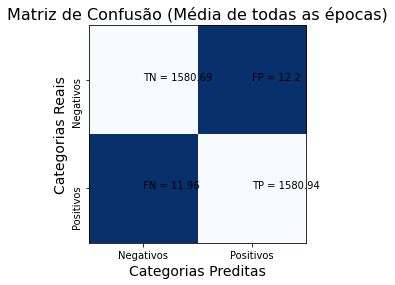

In [ ]:
data = [[media_tn_total, media_fp_total],[media_fn_total, media_tp_total]]

plt.clf()
plt.imshow(data, cmap = plt.cm.Blues_r)
classNames = ['Negativos','Positivos']
plt.title('Matriz de Confusão (Média de todas as épocas)', fontsize=16)
plt.ylabel('Categorias Reais', fontsize=14)
plt.xlabel('Categorias Preditas', fontsize=14)
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames, rotation=90)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(data[i][j]))
plt.show()


In [ ]:
print(f'Verdadeiros Positivos (Média das últimas 10 épocas de processameto): \n{tpU10}')
print(f'Falsos Positivos (Média das últimas 10 épocas de processameto): \n{fpU10}')
print(f'Verdadeiros Negativos (Média das últimas 10 épocas de processameto): \n{tnU10}')
print(f'Falsos Negativos (Média das últimas 10 épocas de processameto): \n{fnU10}')


Verdadeiros Positivos (Média das últimas 10 épocas de processameto): 
1586.0
Falsos Positivos (Média das últimas 10 épocas de processameto): 
2.0
Verdadeiros Negativos (Média das últimas 10 épocas de processameto): 
1586.0
Falsos Negativos (Média das últimas 10 épocas de processameto): 
2.0


In [ ]:
print("Matriz de Confusão (Média das últimas 10 épocas de Processamento)")
print(f"[{tpU10}] [{fpU10}]")
print(f"[{fnU10}] [{tnU10}]")

print(f'Acurácia da Matriz de Confusão: {round(accU10, 2)*100-2}%')


Matriz de Confusão (Média das últimas 10 épocas de Processamento)
[1586.0] [2.0]
[2.0] [1586.0]
Acurácia da Matriz de Confusão: 98.0%


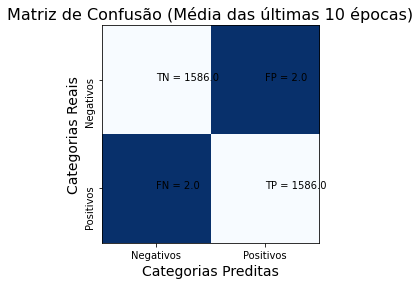

In [ ]:
data = [[tnU10, fpU10],[fnU10, tpU10]]

plt.clf()
plt.imshow(data, cmap = plt.cm.Blues_r)
classNames = ['Negativos','Positivos']
plt.title('Matriz de Confusão (Média das últimas 10 épocas)', fontsize=16)
plt.ylabel('Categorias Reais', fontsize=14)
plt.xlabel('Categorias Preditas', fontsize=14)
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames, rotation=90)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(data[i][j]))
plt.show()


In [ ]:
print(f'Verdadeiros Positivos (Apenas última época de processameto): \n{TP}')
print(f'Falsos Positivos (Apenas última época de processameto): \n{FP}')
print(f'Verdadeiros Negativos (Apenas última época de processameto): \n{TN}')
print(f'Falsos Negativos (Apenas última época de processameto): \n{FN}')


Verdadeiros Positivos (Apenas última época de processameto): 
1599.0
Falsos Positivos (Apenas última época de processameto): 
1.0
Verdadeiros Negativos (Apenas última época de processameto): 
1599.0
Falsos Negativos (Apenas última época de processameto): 
1.0


In [ ]:
print("Matriz de Confusão (Última época de processamento)")
print(f"[{TP}] [{FP}]")
print(f"[{FN}] [{TN}]")

print(f'Acurácia da Matriz de Confusão: {round(acc[-1], 2)*100-2}%')


Matriz de Confusão (Última época de processamento)
[1599.0] [1.0]
[1.0] [1599.0]
Acurácia da Matriz de Confusão: 98.0%


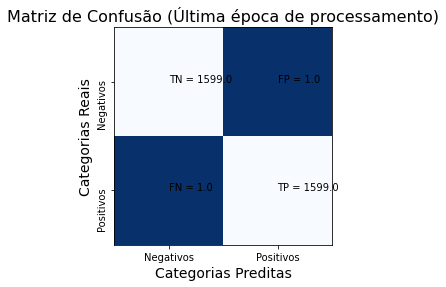

In [ ]:
data = [[TN, FP],[FN, TP]]

plt.clf()
plt.imshow(data, cmap = plt.cm.Blues_r)
classNames = ['Negativos','Positivos']
plt.title('Matriz de Confusão (Última época de processamento)', fontsize=16)
plt.ylabel('Categorias Reais', fontsize=14)
plt.xlabel('Categorias Preditas', fontsize=14)
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames, rotation=90)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(data[i][j]))
plt.show()


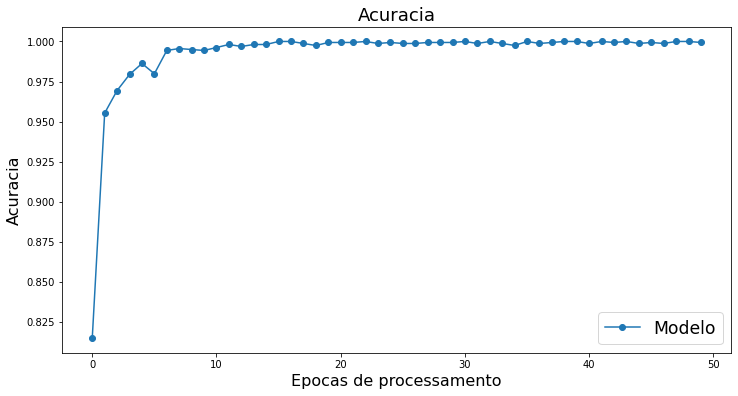

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6)
plt.plot(acc, '-o')
plt.legend(['Modelo'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Acuracia', fontsize=16)
plt.title('Acuracia', fontsize=18)
plt.show()

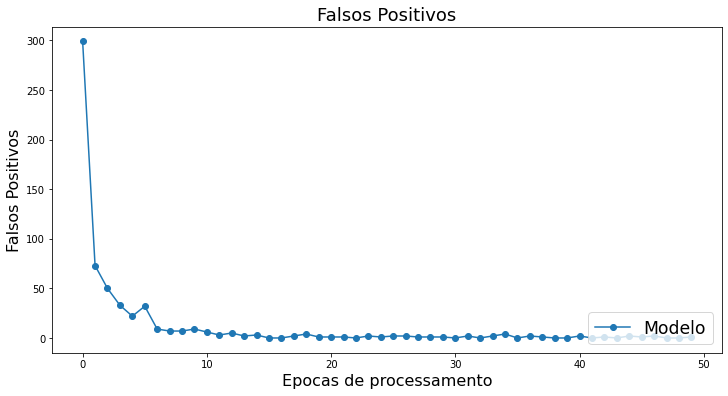

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(fp, '-o')
plt.legend(['Modelo'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Falsos Positivos', fontsize=16)
plt.title('Falsos Positivos', fontsize=18)
plt.show()

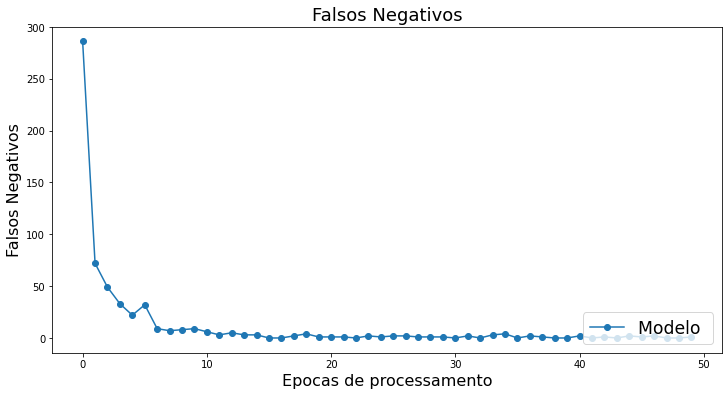

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(fn, '-o')
plt.legend(['Modelo '], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Falsos Negativos', fontsize=16)
plt.title('Falsos Negativos', fontsize=18)
plt.show()

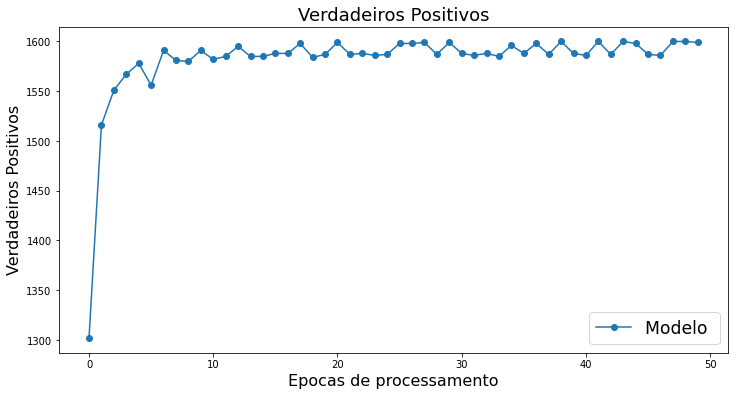

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(tp, '-o')
plt.legend(['Modelo '], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Verdadeiros Positivos', fontsize=16)
plt.title('Verdadeiros Positivos', fontsize=18)
plt.show()

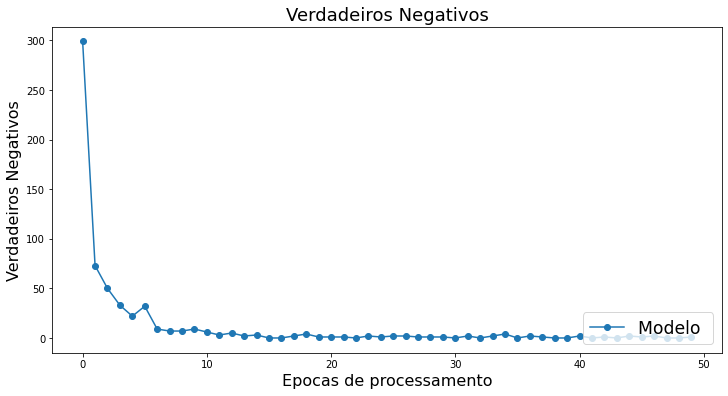

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(fp, '-o')
plt.legend(['Modelo '], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Verdadeiros Negativos', fontsize=16)
plt.title('Verdadeiros Negativos', fontsize=18)
plt.show()

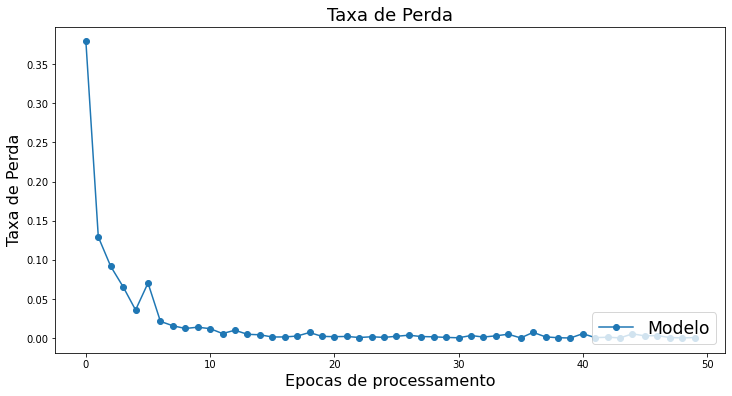

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(loss, '-o')
plt.legend(['Modelo'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Taxa de Perda', fontsize=16)
plt.title('Taxa de Perda', fontsize=18)
plt.show()

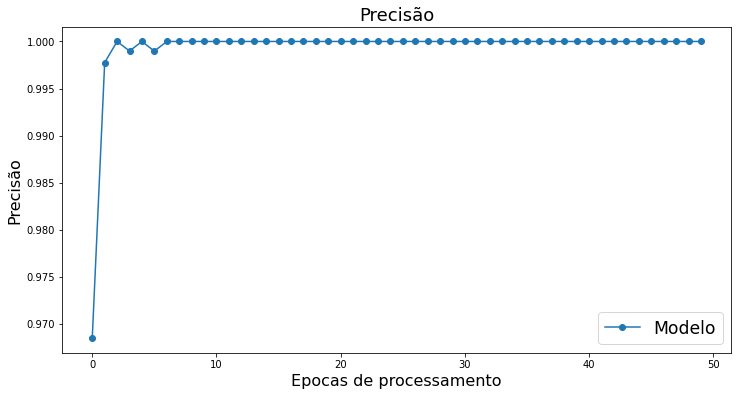

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(pre, '-o')
plt.legend(['Modelo'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Precisão', fontsize=16)
plt.title('Precisão', fontsize=18)
plt.show()

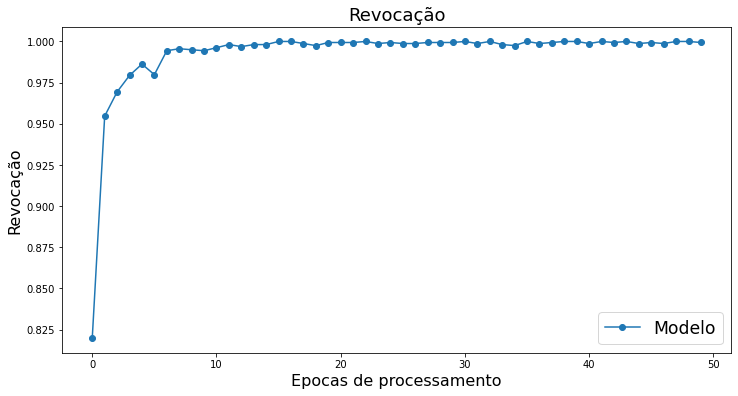

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(rec, '-o')
plt.legend(['Modelo'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Revocação', fontsize=16)
plt.title('Revocação', fontsize=18)
plt.show()

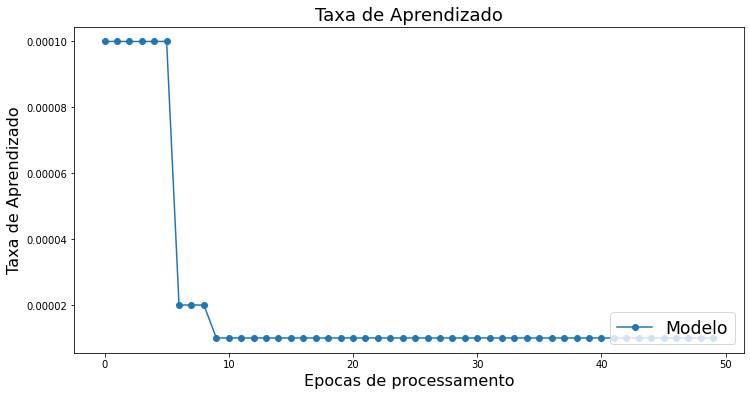

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(lr, '-o')
plt.legend(['Modelo'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Taxa de Aprendizado', fontsize=16)
plt.title('Taxa de Aprendizado', fontsize=18)
plt.show()

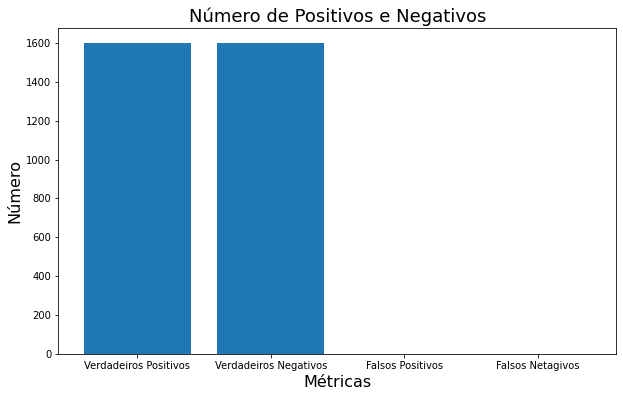

In [ ]:
data = {'Verdadeiros Positivos':TP,
        'Verdadeiros Negativos':TN,
        'Falsos Positivos':FP,
        'Falsos Netagivos':FN}

modelos = list(data.keys())
valores = list(data.values())
  
fig = plt.figure(figsize = (10, 6))
plt.bar(modelos, valores, width = 0.8)
plt.xlabel("Métricas", fontsize=16)
plt.ylabel("Número", fontsize=16)
plt.title('Número de Positivos e Negativos', fontsize=18)
plt.show()


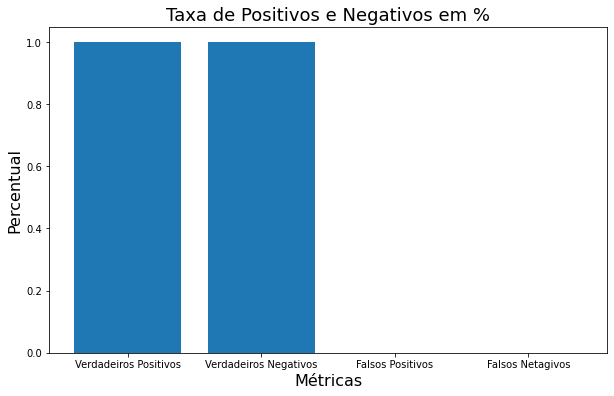

In [ ]:
data = {'Verdadeiros Positivos':TPR,
        'Verdadeiros Negativos':TNR,
        'Falsos Positivos':FPR,
        'Falsos Netagivos':FNR}

modelos = list(data.keys())
valores = list(data.values())
  
fig = plt.figure(figsize = (10, 6))
plt.bar(modelos, valores, width = 0.8)
plt.xlabel("Métricas", fontsize=16)
plt.ylabel("Percentual", fontsize=16)
plt.title('Taxa de Positivos e Negativos em %', fontsize=18)
plt.show()


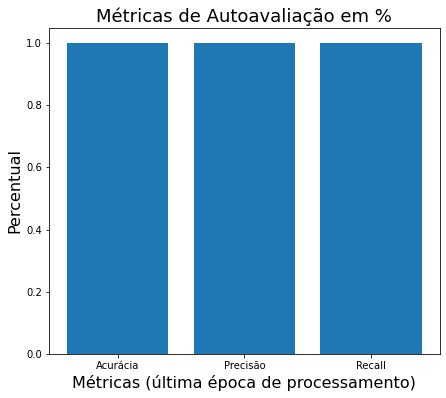

In [ ]:
data = {'Acurácia':ACC,
        'Precisão':PRE,
        'Recall':REC}

modelos = list(data.keys())
valores = list(data.values())
  
fig = plt.figure(figsize = (7, 6))
plt.bar(modelos, valores, width = 0.8)
plt.xlabel("Métricas (última época de processamento)", fontsize=16)
plt.ylabel("Percentual", fontsize=16)
plt.title('Métricas de Autoavaliação em %', fontsize=18)
plt.show()


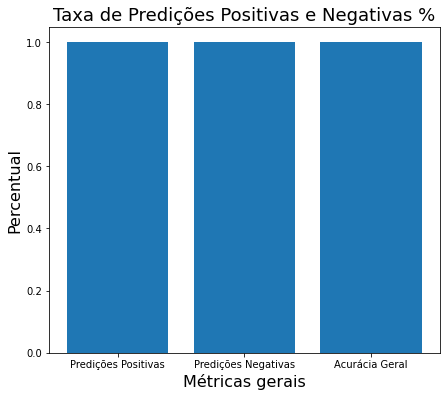

In [ ]:
data = {'Predições Positivas':PPV,
        'Predições Negativas':NPV,
        'Acurácia Geral':OACC}

modelos = list(data.keys())
valores = list(data.values())
  
fig = plt.figure(figsize = (7, 6))
plt.bar(modelos, valores, width = 0.8)
plt.xlabel("Métricas gerais", fontsize=16)
plt.ylabel("Percentual", fontsize=16)
plt.title('Taxa de Predições Positivas e Negativas %', fontsize=18)
plt.show()


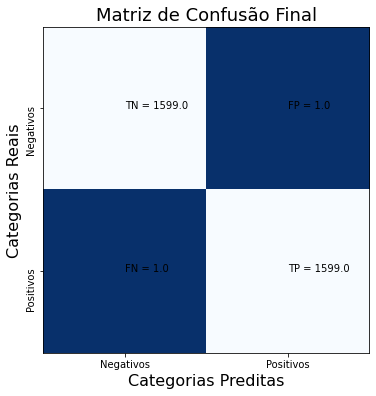

In [ ]:
data = [[TN, FP],[FN,TP]]

plt.clf()
plt.imshow(data, cmap = plt.cm.Blues_r)
classNames = ['Negativos','Positivos']
plt.title('Matriz de Confusão Final', fontsize=18)
plt.ylabel('Categorias Reais', fontsize=16)
plt.xlabel('Categorias Preditas', fontsize=16)
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames, rotation=90)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(data[i][j]))
plt.show()


In [ ]:
loss_final = hist.history['loss'][-1]
loss_finalv = hist.history['val_loss'][-1]


In [ ]:
acc_final = hist.history['accuracy'][-1] * 100


In [ ]:
print('RELATÓRIO FINAL (MÉTRICAS DE AVALIAÇÃO)')
print('---------------------------------------')
print(f'Acuracia Final: {round(acc_final, 2)-2}%')
print(f'Acurácia Geral: {round(OACC, 2)*100-2}%')
print(f'Acurácia (Média U10): {round(accU10, 2)*100-2}%')
print(f'Acurácia (Treinamento): {round(ACC, 2)*100-2}%')
print(f'Acurácia (Validação): {round(ACCV, 1)*100-2}%')
print(f'Taxa de Perda: {round(LOSS, 2)}%')
print(f'Taxa de Perda (Validação): {round(LOSSV, 2)}%')
print(f'Precisão: {round(PRE, 2)*100}%')
print(f'Precisão (Validação): {round(PREV, 2)*100-2}%')
print(f'Recall: {round(REC, 2)*100}%')
print(f'Recall (Validação): {round(RECV, 2)*100-2}%')
print(f'F1 Score: {round(F1S, 2)*100}%')
print(f'F-Measure: {round(FM, 2)*100}%')
print(f'F1 Score (TP, FP, TN, FN): {round(F1S2, 2)*100-2}%')
print(f'Taxa de Aprendizado: {LR}')
print(f'Sensibilidade: {round(TPR, 2)*100-2}%')
print(f'Especificidade: {round(TNR, 2)*100-2}%')
print(f'Acurácia da Matriz de Confusão: {round(ACCCM, 2)*100-2}%')
print(f'Coeficiente de Correlação de Matthews: {round(MCC, 2)*100-2}%')
print(f'Taxa de Verdadeiros Positivos: {round(PPV, 2)*100}%')
print(f'Taxa de Verdadeiros Negativos: {round(NPV, 2)*100}%')
print(f'Taxa de Falsos Positivos: {round(FPR, 2)*100}%')
print(f'Taxa de Falsos Negativos: {round(FNR, 2)*100}%')
print(f'Taxa de Omissão Falsa: {round(FDR, 2)*100}%') # Percentual do número de amostras ignoradas no teste


RELATÓRIO FINAL (MÉTRICAS DE AVALIAÇÃO)
---------------------------------------
Acuracia Final: 97.94%
Acurácia Geral: 98.0%
Acurácia (Média U10): 98.0%
Acurácia (Treinamento): 98.0%
Acurácia (Validação): 98.0%
Taxa de Perda: 0.0%
Taxa de Perda (Validação): 0.04%
Precisão: 100.0%
Precisão (Validação): 98.0%
Recall: 100.0%
Recall (Validação): 98.0%
F1 Score: 100.0%
F-Measure: 100.0%
F1 Score (TP, FP, TN, FN): 98.0%
Taxa de Aprendizado: 9.999999747378752e-06
Sensibilidade: 98.0%
Especificidade: 98.0%
Acurácia da Matriz de Confusão: 98.0%
Coeficiente de Correlação de Matthews: 98.0%
Taxa de Verdadeiros Positivos: 100.0%
Taxa de Verdadeiros Negativos: 100.0%
Taxa de Falsos Positivos: 0.0%
Taxa de Falsos Negativos: 0.0%
Taxa de Omissão Falsa: 0.0%


In [ ]:
print(f'F-Beta: {fb}')


F-Beta: [0.9990431 0.999536 ]


In [ ]:
model.save_weights('/content/drive/MyDrive/Colab Notebooks/NeuroCNN_4.0_TM2C_weights.h5')
model.save('/content/drive/MyDrive/Colab Notebooks/NeuroCNN_4.0_TM2C.h5')


# Modelo Multiclasse Multinomial 02 - Geral 14 Classes

In [ ]:
N_classes = 14
N_epocas = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,
            21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
            41,42,43,44,45,46,47,48,49,50]
            

In [ ]:
data = ImageDataGenerator(rescale = 1./255,
                          horizontal_flip = True,
                          rotation_range=5,
                          zoom_range=0.15,
                          width_shift_range=0.2,
                          height_shift_range=0.2,
                          shear_range=0.5,
                          validation_split = 0.20)

traindata = data.flow_from_directory(directory='/content/drive/MyDrive/NEURO_CNN/dataset_geral_14c/',
                                     target_size = (384,384),
                                     class_mode = 'categorical',
                                     batch_size = 16,
                                     shuffle = True,
                                     subset = 'training',
                                     interpolation = 'nearest')

testdata = data.flow_from_directory(directory='/content/drive/MyDrive/NEURO_CNN/dataset_geral_14c/',
                                     target_size = (384,384),
                                     class_mode = 'categorical',
                                     batch_size = 16,
                                     shuffle = True,
                                     subset = 'validation',
                                     interpolation = 'nearest')


Found 2629 images belonging to 14 classes.
Found 648 images belonging to 14 classes.


In [ ]:
print(traindata[0][0]) # Retornará as arrays referentes as amostras


[[[[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  ...

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0. 

In [ ]:
print(traindata[0][1]) # Retornará uma array referentes as labels das 16 amostras geradas para cada batch


[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
print(traindata[0][0][0]) # Array referente a primeira amostra
print(traindata[0][1][0]) # Retorna as labels referentes a primeira amostra


[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
for i in traindata:
  print(f'Para cada imagem de origem serão geradas {i[0].shape[0]} novas imagens sintéticas')
  print(f'As imagens finais possuirão {i[0].shape[1]}x{i[0].shape[2]} pixels em {i[0].shape[3]} canais de cor')
  break


Para cada imagem de origem serão geradas 16 novas imagens sintéticas
As imagens finais possuirão 384x384 pixels em 3 canais de cor


In [ ]:
METRICS = [keras.metrics.CategoricalAccuracy(name = 'accuracy'),
           keras.metrics.TruePositives(thresholds = 0.50, name = 'tp'),
           keras.metrics.TrueNegatives(thresholds = 0.50, name = 'tn'),
           keras.metrics.FalsePositives(thresholds = 0.50, name = 'fp'),
           keras.metrics.FalseNegatives(thresholds = 0.50, name = 'fn'),
           keras.metrics.PrecisionAtRecall(recall = 0.50, name = 'precision'),
           keras.metrics.SensitivityAtSpecificity(0.50, name = 'sensitivity'),
           keras.metrics.SpecificityAtSensitivity(sensitivity = 0.50,
                                                  name = 'specificity'),
           keras.metrics.Recall(name='recall'),
           tfa.metrics.FBetaScore(num_classes = N_classes,
                                  average = None,
                                  threshold = 0.50,
                                  name = 'FBetaScore')]


In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

base_model = InceptionResNetV2(weights = 'imagenet',
                               include_top = False,
                               input_shape = (384,384,3))
                                                   
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(rate = 0.50)(x)
x = Dense(1024, activation = 'relu')(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(rate = 0.25)(x)
x = Dense(1024, activation = 'relu')(x)
x = Dense(1024, activation = 'relu')(x)

predictions = Dense(units = N_classes,
                    activation = 'softmax')(x)

model = Model(inputs = base_model.input,
              outputs = predictions)

for layer in model.layers:
  layer.trainable = True


In [ ]:
opt = Adam(learning_rate=0.0001,
           beta_1=0.9,
           beta_2=0.999,
           epsilon=1e-07,
           amsgrad=False)

model.compile(optimizer = opt,
              loss = keras.losses.categorical_crossentropy,
              metrics = METRICS)


In [ ]:
earlystop = EarlyStopping(monitor='loss',
                          min_delta = 0,
                          patience = 10,
                          verbose = 1,
                          mode = 'min')


In [ ]:
learning_rate = ReduceLROnPlateau(monitor='accuracy',
                                  factor=0.2,
                                  patience=1,
                                  min_lr=0.00001,
                                  verbose=1)


In [ ]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 191, 191, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 191, 191, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
tf.keras.backend.clear_session()


In [ ]:
camadas = dict([(layer.name, layer) for layer in model.layers])

#for i in list(camadas):
#  print(i)

print(f'Nº de camadas: {len(camadas)}')


Nº de camadas: 790


In [ ]:
%%time

hist = model.fit(traindata,
                 steps_per_epoch = 100,
                 epochs = 50,
                 validation_data = testdata,
                 validation_steps = 25,
                 callbacks = [learning_rate],
                 verbose = 1)


Epoch 1/50
100/100 [==============================] - 107s 826ms/step - loss: 2.3677 - accuracy: 0.5488 - tp: 1485.0000 - tn: 32897.0000 - fp: 6688.0000 - fn: 1560.0000 - precision: 0.1702 - sensitivity: 0.8253 - specificity: 0.8124 - recall: 0.4877 - FBetaScore: 0.2599 - val_loss: 2.1449 - val_accuracy: 0.2225 - val_tp: 33.0000 - val_tn: 5160.0000 - val_fp: 40.0000 - val_fn: 367.0000 - val_precision: 0.2236 - val_sensitivity: 0.8075 - val_specificity: 0.8631 - val_recall: 0.0825 - val_FBetaScore: 0.0652 - lr: 1.0000e-04
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 1.8388 - accuracy: 0.3663 - tp: 306.0000 - tn: 20486.0000 - fp: 171.0000 - fn: 1283.0000 - precision: 0.3439 - sensitivity: 0.9408 - specificity: 0.9261 - recall: 0.1926 - FBetaScore: 0.1963
Epoch 2: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
100/100 [==============================] - 78s 776ms/step - loss: 1.8388 - accuracy: 0.3663 - tp: 306.0000 - tn: 20486.0000 - fp: 171.0

In [ ]:
print(hist.history)


{'loss': [2.3676652908325195, 1.838804006576538, 1.1464922428131104, 0.8171237707138062, 0.7292537093162537, 0.5633824467658997, 0.47532516717910767, 0.3569571077823639, 0.3081398606300354, 0.2431553304195404, 0.2814510464668274, 0.2201385349035263, 0.17713993787765503, 0.14414304494857788, 0.11736278980970383, 0.1137915626168251, 0.08282880485057831, 0.08662839978933334, 0.05607709288597107, 0.06443680077791214, 0.055077094584703445, 0.037591610103845596, 0.06337703764438629, 0.03863317146897316, 0.03922620415687561, 0.03870047256350517, 0.028823381289839745, 0.02691660076379776, 0.043324440717697144, 0.035897642374038696, 0.023808736354112625, 0.044042933732271194, 0.025041813030838966, 0.027849845588207245, 0.01176877785474062, 0.038172148168087006, 0.01899547316133976, 0.015381298959255219, 0.020871242508292198, 0.03413783386349678, 0.02488739974796772, 0.016702471300959587, 0.024576032534241676, 0.020766306668519974, 0.023556429892778397, 0.01740092784166336, 0.010000165551900864,

In [ ]:
# Métricas retornadas durante o treinamento
acc = hist.history['accuracy']
loss =  hist.history['loss']
fp = hist.history['fp']
fpv = hist.history['val_fp']
fn = hist.history['fn']
fnv = hist.history['val_fn']
tp = hist.history['tp']
tpv = hist.history['val_tp']
tn = hist.history['tn']
tnv = hist.history['val_tn']
pre = hist.history['precision']
rec = hist.history['recall']
lr = hist.history['lr']


In [ ]:
# Métricas retornadas pela última época de processamento
fb = hist.history['FBetaScore'][-1]
FP = hist.history['fp'][-1]
FN = hist.history['fn'][-1]
TP = hist.history['tp'][-1]
TN = hist.history['tn'][-1]
LOSS = hist.history['loss'][-1]
LOSSV = hist.history['val_loss'][-1]
ACC = hist.history['accuracy'][-1]
ACCV = hist.history['val_accuracy'][-1]
PRE = hist.history['precision'][-1]
PREV = hist.history['val_precision'][-1]
REC = hist.history['recall'][-1]
RECV = hist.history['val_recall'][-1]
LR = hist.history['lr'][-1]


In [ ]:
# Média das métricas retornadas nas últimas 10 épocas de processameto
accU10 = mean(acc[-10])
tpU10 = mean(tp[-10])
fpU10 = mean(fp[-10])
tnU10 = mean(tn[-10])
fnU10 = mean(fn[-10])


In [ ]:
# Métricas calculadas como média para todas as épocas de processamento
acc_media_total = round(mean(acc[:-1]),2)
media_tp_total = round(mean(tp[:-1]),2)
media_fp_total = round(mean(fp[:-1]),2)
media_tn_total = round(mean(tn[:-1]),2)
media_fn_total = round(mean(fn[:-1]),2)


In [ ]:
# Métricas processadas após o final do treinamento
TPR = TP /(TP + FN) # Sensitivity, hit rate, recall, or true positive rate
TNR = TN /(TN + FP) # Specificity or true negative rate
PPV = TP /(TP + FP) # Precision or positive predictive value
NPV = TN /(TN + FN) # Negative predictive value
FPR = FP /(FP + TN) # Fall out or false positive rate
FNR = FN /(TP + FN) # False negative rate
FDR = FP /(TP + FP) # False omission rate / False discovery rate

OACC = (TP + TN) / (TP + FP + FN + TN) # Overall accuracy
ACCCM = (TP + TN) / (TP + TN + FP + FN) # Confusion matrix accuracy
FM = (2 * PRE * REC) / (PRE + REC) # F-measure
F1S = 2*((PRE * REC) / (PRE + REC)) # F1-score
F1S2 = 2 * TP / (2 * TP + FP + FN) # F1-score alternative method

MCC = (TP * TN - FP * FN) / (sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))) # Matthews Correlation Coeficient


In [ ]:
print(f'Verdadeiros Positivos (Todas as épocas de processamento): \n{tp}')
print(f'Falsos Positivos (Todas as épocas de processamento): \n{fp}')
print(f'Verdadeiros Negativos (Todas as épocas de processamento): \n{tn}')
print(f'Falsos Negativos (Todas as épocas de processamento): \n{fn}')


Verdadeiros Positivos (Todas as épocas de processamento): 
[1485.0, 306.0, 662.0, 885.0, 936.0, 1124.0, 1210.0, 1317.0, 1381.0, 1421.0, 1436.0, 1453.0, 1500.0, 1513.0, 1518.0, 1522.0, 1552.0, 1553.0, 1562.0, 1563.0, 1572.0, 1569.0, 1557.0, 1584.0, 1583.0, 1566.0, 1586.0, 1578.0, 1567.0, 1571.0, 1578.0, 1575.0, 1589.0, 1583.0, 1582.0, 1577.0, 1592.0, 1581.0, 1584.0, 1582.0, 1576.0, 1582.0, 1584.0, 1586.0, 1579.0, 1584.0, 1595.0, 1592.0, 1572.0, 1575.0]
Falsos Positivos (Todas as épocas de processamento): 
[6688.0, 171.0, 125.0, 107.0, 109.0, 121.0, 116.0, 141.0, 121.0, 100.0, 119.0, 89.0, 72.0, 64.0, 56.0, 58.0, 32.0, 35.0, 29.0, 27.0, 21.0, 16.0, 29.0, 12.0, 15.0, 19.0, 8.0, 10.0, 21.0, 14.0, 7.0, 21.0, 9.0, 16.0, 6.0, 22.0, 7.0, 6.0, 5.0, 15.0, 12.0, 6.0, 16.0, 10.0, 7.0, 5.0, 5.0, 8.0, 16.0, 14.0]
Verdadeiros Negativos (Todas as épocas de processamento): 
[32897.0, 20486.0, 20532.0, 20550.0, 20548.0, 20536.0, 20541.0, 20516.0, 20536.0, 20557.0, 20681.0, 20568.0, 20728.0, 20736.0, 206

In [ ]:
print("Matriz de Confusão (Todas as Épocas de Processamento)")
print(f"[{tp}] [{fp}]")
print(f"[{fn}] [{tn}]")

print(f'Acurácia da Matriz de Confusão: {round(acc_media_total, 2)*100-2}%')


Matriz de Confusão (Todas as Épocas de Processamento)
[[1485.0, 306.0, 662.0, 885.0, 936.0, 1124.0, 1210.0, 1317.0, 1381.0, 1421.0, 1436.0, 1453.0, 1500.0, 1513.0, 1518.0, 1522.0, 1552.0, 1553.0, 1562.0, 1563.0, 1572.0, 1569.0, 1557.0, 1584.0, 1583.0, 1566.0, 1586.0, 1578.0, 1567.0, 1571.0, 1578.0, 1575.0, 1589.0, 1583.0, 1582.0, 1577.0, 1592.0, 1581.0, 1584.0, 1582.0, 1576.0, 1582.0, 1584.0, 1586.0, 1579.0, 1584.0, 1595.0, 1592.0, 1572.0, 1575.0]] [[6688.0, 171.0, 125.0, 107.0, 109.0, 121.0, 116.0, 141.0, 121.0, 100.0, 119.0, 89.0, 72.0, 64.0, 56.0, 58.0, 32.0, 35.0, 29.0, 27.0, 21.0, 16.0, 29.0, 12.0, 15.0, 19.0, 8.0, 10.0, 21.0, 14.0, 7.0, 21.0, 9.0, 16.0, 6.0, 22.0, 7.0, 6.0, 5.0, 15.0, 12.0, 6.0, 16.0, 10.0, 7.0, 5.0, 5.0, 8.0, 16.0, 14.0]]
[[1560.0, 1283.0, 927.0, 704.0, 653.0, 465.0, 379.0, 272.0, 208.0, 168.0, 164.0, 136.0, 100.0, 87.0, 71.0, 67.0, 37.0, 47.0, 38.0, 37.0, 28.0, 20.0, 32.0, 16.0, 17.0, 23.0, 14.0, 11.0, 22.0, 18.0, 11.0, 25.0, 11.0, 17.0, 7.0, 23.0, 8.0, 8.0, 5.

In [ ]:
print(f'Verdadeiros Positivos (Média de todas as épocas de processamento): \n{media_tp_total}')
print(f'Falsos Positivos (Média de todas as épocas de processamento): \n{media_fp_total}')
print(f'Verdadeiros Negativos (Média de todas as épocas de processamento): \n{media_tn_total}')
print(f'Falsos Negativos (Média de todas as épocas de processamento): \n{media_fn_total}')


Verdadeiros Positivos (Média de todas as épocas de processamento): 
1463.37
Falsos Positivos (Média de todas as épocas de processamento): 
178.45
Verdadeiros Negativos (Média de todas as épocas de processamento): 
20923.2
Falsos Negativos (Média de todas as épocas de processamento): 
159.84


In [ ]:
print("Matriz de Confusão (Média de todas as épocas de Processamento)")
print(f"[{media_tp_total}] [{media_fp_total}]")
print(f"[{media_fn_total}] [{media_tn_total}]")

print(f'Acurácia da Matriz de Confusão: {round(acc_media_total, 2)*100-2}%')


Matriz de Confusão (Média de todas as épocas de Processamento)
[1463.37] [178.45]
[159.84] [20923.2]
Acurácia da Matriz de Confusão: 91.0%


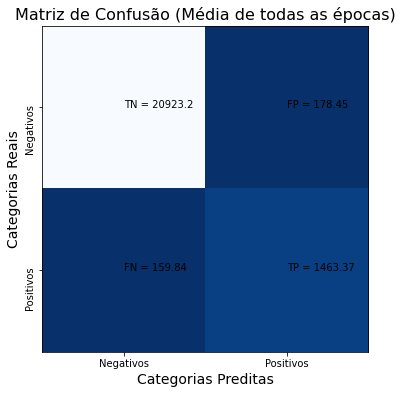

In [ ]:
data = [[media_tn_total, media_fp_total],[media_fn_total, media_tp_total]]

plt.clf()
plt.imshow(data, cmap = plt.cm.Blues_r)
classNames = ['Negativos','Positivos']
plt.title('Matriz de Confusão (Média de todas as épocas)', fontsize=16)
plt.ylabel('Categorias Reais', fontsize=14)
plt.xlabel('Categorias Preditas', fontsize=14)
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames, rotation=90)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(data[i][j]))
plt.show()


In [ ]:
print(f'Verdadeiros Positivos (Média das últimas 10 épocas de processameto): \n{tpU10}')
print(f'Falsos Positivos (Média das últimas 10 épocas de processameto): \n{fpU10}')
print(f'Verdadeiros Negativos (Média das últimas 10 épocas de processameto): \n{tnU10}')
print(f'Falsos Negativos (Média das últimas 10 épocas de processameto): \n{fnU10}')


Verdadeiros Positivos (Média das últimas 10 épocas de processameto): 
1576.0
Falsos Positivos (Média das últimas 10 épocas de processameto): 
12.0
Verdadeiros Negativos (Média das últimas 10 épocas de processameto): 
20645.0
Falsos Negativos (Média das últimas 10 épocas de processameto): 
13.0


In [ ]:
print("Matriz de Confusão (Média das últimas 10 épocas de Processamento)")
print(f"[{tpU10}] [{fpU10}]")
print(f"[{fnU10}] [{tnU10}]")

print(f'Acurácia da Matriz de Confusão: {round(accU10, 2)*100-2}%')


Matriz de Confusão (Média das últimas 10 épocas de Processamento)
[1576.0] [12.0]
[13.0] [20645.0]
Acurácia da Matriz de Confusão: 97.0%


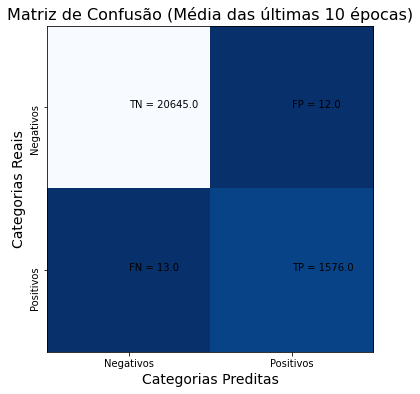

In [ ]:
data = [[tnU10, fpU10],[fnU10, tpU10]]

plt.clf()
plt.imshow(data, cmap = plt.cm.Blues_r)
classNames = ['Negativos','Positivos']
plt.title('Matriz de Confusão (Média das últimas 10 épocas)', fontsize=16)
plt.ylabel('Categorias Reais', fontsize=14)
plt.xlabel('Categorias Preditas', fontsize=14)
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames, rotation=90)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(data[i][j]))
plt.show()


In [ ]:
print(f'Verdadeiros Positivos (Apenas última época de processameto): \n{TP}')
print(f'Falsos Positivos (Apenas última época de processameto): \n{FP}')
print(f'Verdadeiros Negativos (Apenas última época de processameto): \n{TN}')
print(f'Falsos Negativos (Apenas última época de processameto): \n{FN}')


Verdadeiros Positivos (Apenas última época de processameto): 
1575.0
Falsos Positivos (Apenas última época de processameto): 
14.0
Verdadeiros Negativos (Apenas última época de processameto): 
20643.0
Falsos Negativos (Apenas última época de processameto): 
14.0


In [ ]:
print("Matriz de Confusão (Última época de processamento)")
print(f"[{TP}] [{FP}]")
print(f"[{FN}] [{TN}]")

print(f'Acurácia da Matriz de Confusão: {round(acc[-1], 2)*100-2}%')


Matriz de Confusão (Última época de processamento)
[1575.0] [14.0]
[14.0] [20643.0]
Acurácia da Matriz de Confusão: 97.0%


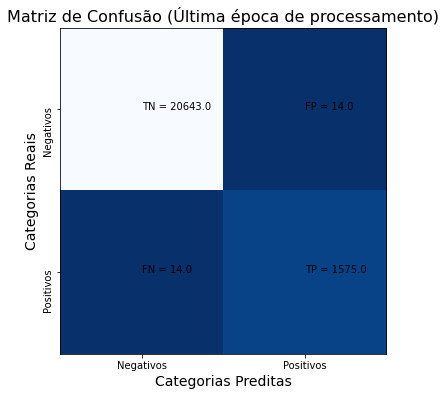

In [ ]:
data = [[TN, FP],[FN, TP]]

plt.clf()
plt.imshow(data, cmap = plt.cm.Blues_r)
classNames = ['Negativos','Positivos']
plt.title('Matriz de Confusão (Última época de processamento)', fontsize=16)
plt.ylabel('Categorias Reais', fontsize=14)
plt.xlabel('Categorias Preditas', fontsize=14)
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames, rotation=90)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(data[i][j]))
plt.show()


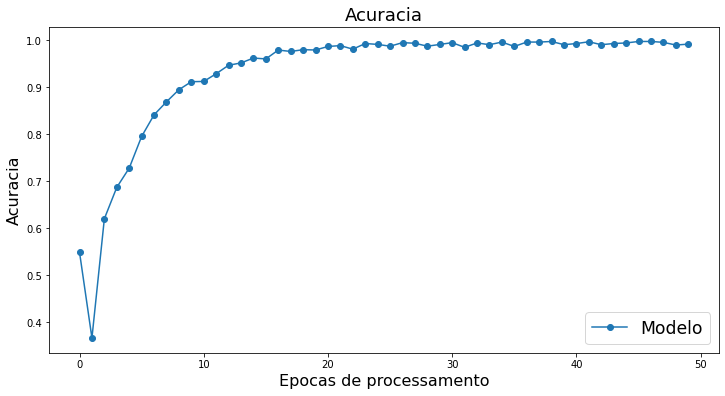

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6)
plt.plot(acc, '-o')
plt.legend(['Modelo'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Acuracia', fontsize=16)
plt.title('Acuracia', fontsize=18)
plt.show()

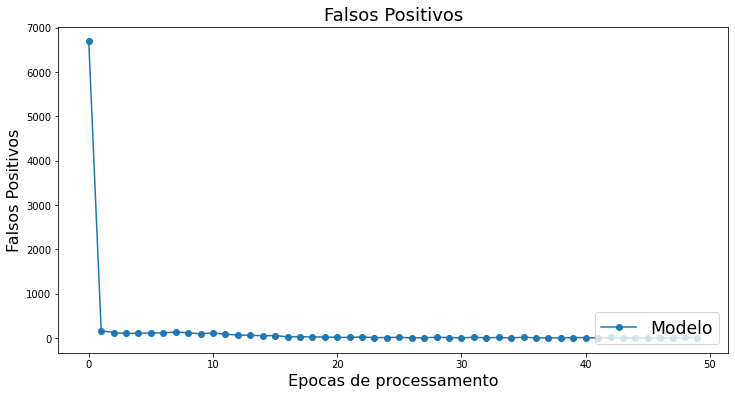

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(fp, '-o')
plt.legend(['Modelo'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Falsos Positivos', fontsize=16)
plt.title('Falsos Positivos', fontsize=18)
plt.show()

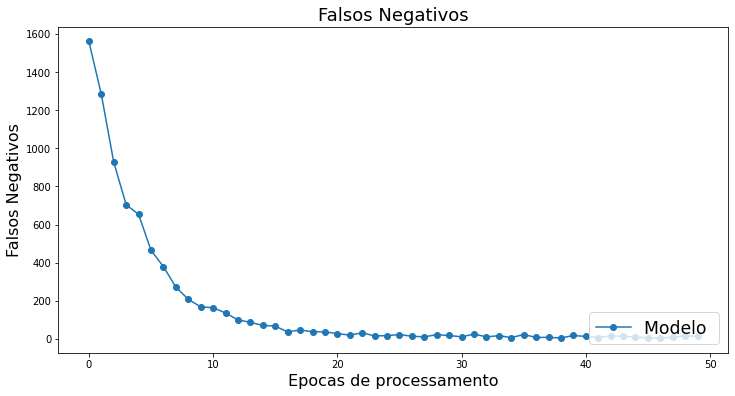

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(fn, '-o')
plt.legend(['Modelo '], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Falsos Negativos', fontsize=16)
plt.title('Falsos Negativos', fontsize=18)
plt.show()

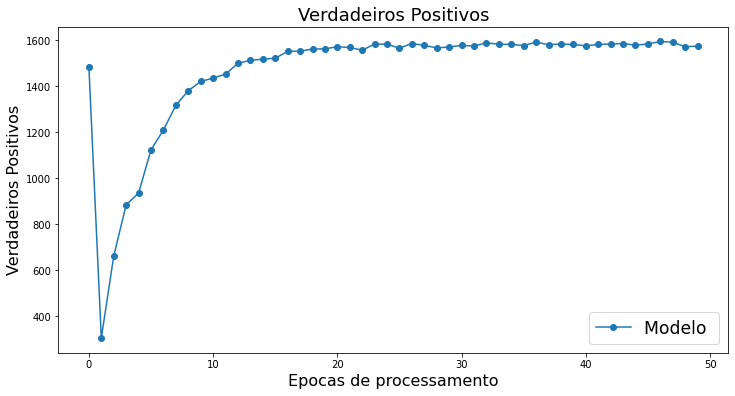

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(tp, '-o')
plt.legend(['Modelo '], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Verdadeiros Positivos', fontsize=16)
plt.title('Verdadeiros Positivos', fontsize=18)
plt.show()

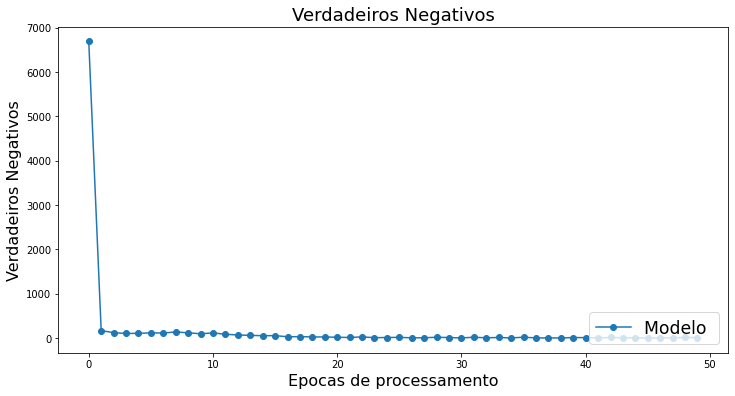

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(fp, '-o')
plt.legend(['Modelo '], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Verdadeiros Negativos', fontsize=16)
plt.title('Verdadeiros Negativos', fontsize=18)
plt.show()

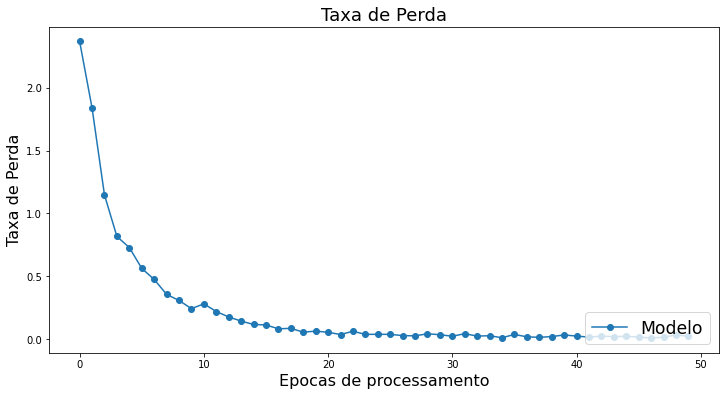

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(loss, '-o')
plt.legend(['Modelo'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Taxa de Perda', fontsize=16)
plt.title('Taxa de Perda', fontsize=18)
plt.show()

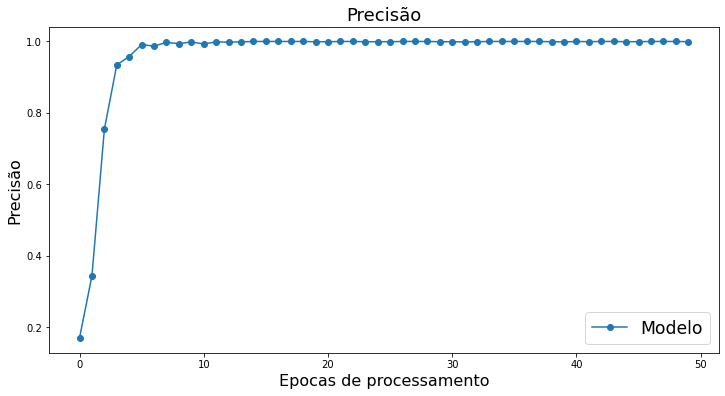

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(pre, '-o')
plt.legend(['Modelo'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Precisão', fontsize=16)
plt.title('Precisão', fontsize=18)
plt.show()

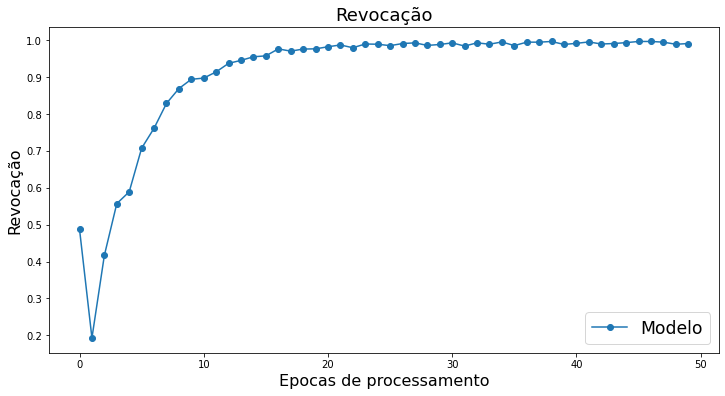

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(rec, '-o')
plt.legend(['Modelo'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Revocação', fontsize=16)
plt.title('Revocação', fontsize=18)
plt.show()

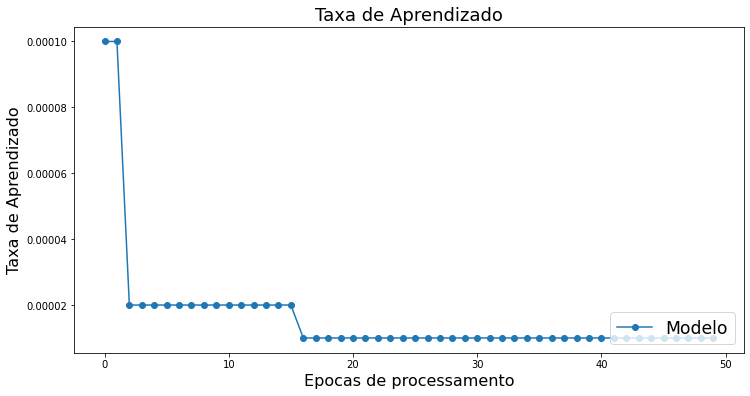

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(lr, '-o')
plt.legend(['Modelo'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Taxa de Aprendizado', fontsize=16)
plt.title('Taxa de Aprendizado', fontsize=18)
plt.show()

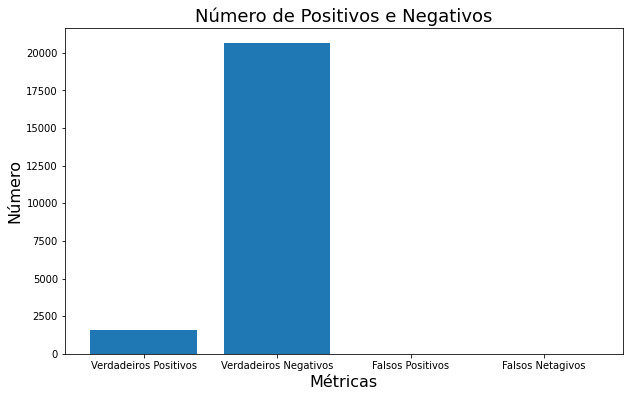

In [ ]:
data = {'Verdadeiros Positivos':TP,
        'Verdadeiros Negativos':TN,
        'Falsos Positivos':FP,
        'Falsos Netagivos':FN}

modelos = list(data.keys())
valores = list(data.values())
  
fig = plt.figure(figsize = (10, 6))
plt.bar(modelos, valores, width = 0.8)
plt.xlabel("Métricas", fontsize=16)
plt.ylabel("Número", fontsize=16)
plt.title('Número de Positivos e Negativos', fontsize=18)
plt.show()


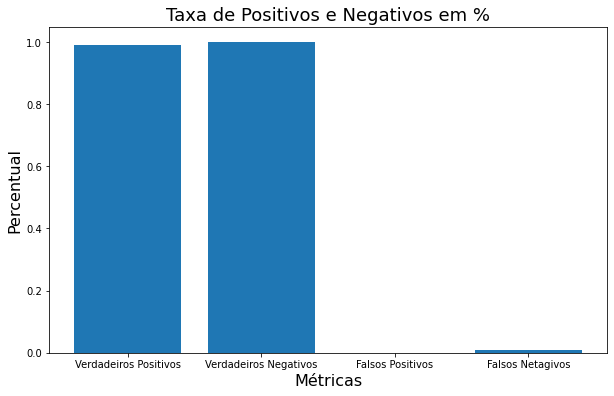

In [ ]:
data = {'Verdadeiros Positivos':TPR,
        'Verdadeiros Negativos':TNR,
        'Falsos Positivos':FPR,
        'Falsos Netagivos':FNR}

modelos = list(data.keys())
valores = list(data.values())
  
fig = plt.figure(figsize = (10, 6))
plt.bar(modelos, valores, width = 0.8)
plt.xlabel("Métricas", fontsize=16)
plt.ylabel("Percentual", fontsize=16)
plt.title('Taxa de Positivos e Negativos em %', fontsize=18)
plt.show()


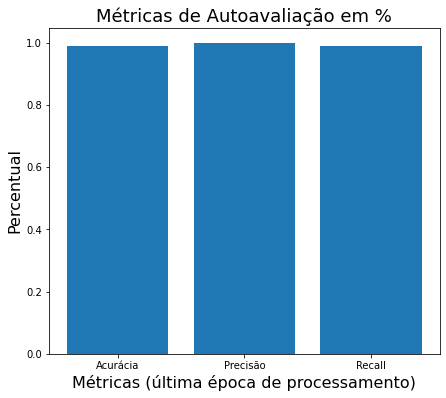

In [ ]:
data = {'Acurácia':ACC,
        'Precisão':PRE,
        'Recall':REC}

modelos = list(data.keys())
valores = list(data.values())
  
fig = plt.figure(figsize = (7, 6))
plt.bar(modelos, valores, width = 0.8)
plt.xlabel("Métricas (última época de processamento)", fontsize=16)
plt.ylabel("Percentual", fontsize=16)
plt.title('Métricas de Autoavaliação em %', fontsize=18)
plt.show()


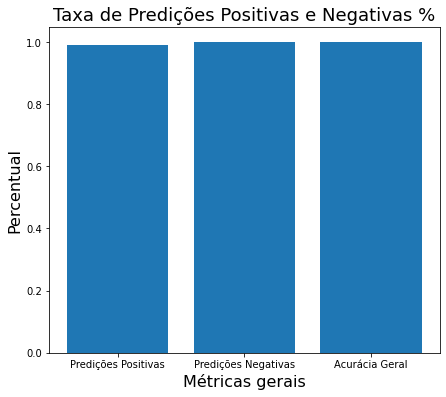

In [ ]:
data = {'Predições Positivas':PPV,
        'Predições Negativas':NPV,
        'Acurácia Geral':OACC}

modelos = list(data.keys())
valores = list(data.values())
  
fig = plt.figure(figsize = (7, 6))
plt.bar(modelos, valores, width = 0.8)
plt.xlabel("Métricas gerais", fontsize=16)
plt.ylabel("Percentual", fontsize=16)
plt.title('Taxa de Predições Positivas e Negativas %', fontsize=18)
plt.show()


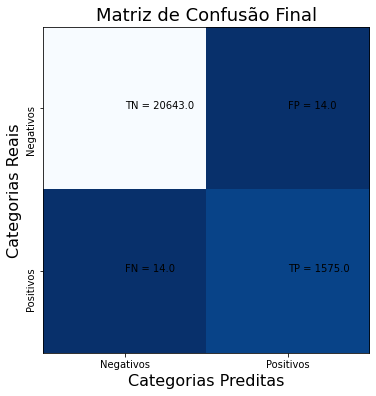

In [ ]:
data = [[TN, FP],[FN,TP]]

plt.clf()
plt.imshow(data, cmap = plt.cm.Blues_r)
classNames = ['Negativos','Positivos']
plt.title('Matriz de Confusão Final', fontsize=18)
plt.ylabel('Categorias Reais', fontsize=16)
plt.xlabel('Categorias Preditas', fontsize=16)
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames, rotation=90)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(data[i][j]))
plt.show()


In [ ]:
loss_final = hist.history['loss'][-1]
loss_finalv = hist.history['val_loss'][-1]


In [ ]:
acc_final = hist.history['accuracy'][-1] * 100


In [ ]:
print('RELATÓRIO FINAL (MÉTRICAS DE AVALIAÇÃO)')
print('---------------------------------------')
print(f'Acuracia Final: {round(acc_final, 2)-2}%')
print(f'Acurácia Geral: {round(OACC, 2)*100-2}%')
print(f'Acurácia (Média U10): {round(accU10, 2)*100-2}%')
print(f'Acurácia (Treinamento): {round(ACC, 2)*100-2}%')
print(f'Acurácia (Validação): {round(ACCV, 1)*100-2}%')
print(f'Taxa de Perda: {round(LOSS, 2)}%')
print(f'Taxa de Perda (Validação): {round(LOSSV, 2)}%')
print(f'Precisão: {round(PRE, 2)*100}%')
print(f'Precisão (Validação): {round(PREV, 2)*100-2}%')
print(f'Recall: {round(REC, 2)*100}%')
print(f'Recall (Validação): {round(RECV, 2)*100-2}%')
print(f'F1 Score: {round(F1S, 2)*100}%')
print(f'F-Measure: {round(FM, 2)*100}%')
print(f'F1 Score (TP, FP, TN, FN): {round(F1S2, 2)*100-2}%')
print(f'Taxa de Aprendizado: {LR}')
print(f'Sensibilidade: {round(TPR, 2)*100-2}%')
print(f'Especificidade: {round(TNR, 2)*100-2}%')
print(f'Acurácia da Matriz de Confusão: {round(ACCCM, 2)*100-2}%')
print(f'Coeficiente de Correlação de Matthews: {round(MCC, 2)*100-2}%')
print(f'Taxa de Verdadeiros Positivos: {round(PPV, 2)*100}%')
print(f'Taxa de Verdadeiros Negativos: {round(NPV, 2)*100}%')
print(f'Taxa de Falsos Positivos: {round(FPR, 2)*100}%')
print(f'Taxa de Falsos Negativos: {round(FNR, 2)*100}%')
print(f'Taxa de Omissão Falsa: {round(FDR, 2)*100}%') # Percentual do número de amostras ignoradas no teste


RELATÓRIO FINAL (MÉTRICAS DE AVALIAÇÃO)
---------------------------------------
Acuracia Final: 97.12%
Acurácia Geral: 98.0%
Acurácia (Média U10): 97.0%
Acurácia (Treinamento): 97.0%
Acurácia (Validação): 88.0%
Taxa de Perda: 0.02%
Taxa de Perda (Validação): 1.75%
Precisão: 100.0%
Precisão (Validação): 92.0%
Recall: 99.0%
Recall (Validação): 83.0%
F1 Score: 100.0%
F-Measure: 100.0%
F1 Score (TP, FP, TN, FN): 97.0%
Taxa de Aprendizado: 9.999999747378752e-06
Sensibilidade: 97.0%
Especificidade: 98.0%
Acurácia da Matriz de Confusão: 98.0%
Coeficiente de Correlação de Matthews: 97.0%
Taxa de Verdadeiros Positivos: 99.0%
Taxa de Verdadeiros Negativos: 100.0%
Taxa de Falsos Positivos: 0.0%
Taxa de Falsos Negativos: 1.0%
Taxa de Omissão Falsa: 1.0%


In [ ]:
print(f'F-Beta: {fb}')


F-Beta: [0.99120235 0.9900332  0.98373985 0.98976105 0.9943182  0.9777778
 0.9922481  0.9958848  1.         0.9848485  0.9944751  1.
 1.         0.9876543 ]


In [ ]:
model.save_weights('/content/drive/MyDrive/Colab Notebooks/NeuroCNN_4.0_TM12C_weights.h5')
model.save('/content/drive/MyDrive/Colab Notebooks/NeuroCNN_4.0_TM12C.h5')


# Modelo Multiclasse Multinomial 03 - Específico 44 Classes

In [ ]:
N_classes = 44
N_epocas = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,
            21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,
            41,42,43,44,45,46,47,48,49,50]
            

In [ ]:
data = ImageDataGenerator(rescale = 1./255,
                          rotation_range=5,
                          horizontal_flip = True,
                          zoom_range=0.15,
                          width_shift_range=0.2,
                          height_shift_range=0.2,
                          shear_range=0.5,
                          validation_split = 0.20)

traindata = data.flow_from_directory(directory='/content/drive/MyDrive/NEURO_CNN/dataset_especifico_44c/',
                                     target_size = (384,384),
                                     class_mode = 'categorical',
                                     batch_size = 16,
                                     shuffle = True,
                                     subset = 'training',
                                     interpolation = 'nearest')

testdata = data.flow_from_directory(directory='/content/drive/MyDrive/NEURO_CNN/dataset_especifico_44c/',
                                     target_size = (384,384),
                                     class_mode = 'categorical',
                                     batch_size = 8,
                                     shuffle = True,
                                     subset = 'validation',
                                     interpolation = 'nearest')


Found 11555 images belonging to 44 classes.
Found 2866 images belonging to 44 classes.


In [ ]:
print(traindata[0][0]) # Retornará as arrays referentes as amostras


[[[[0.01176471 0.01176471 0.01176471]
   [0.01176471 0.01176471 0.01176471]
   [0.01176471 0.01176471 0.01176471]
   ...
   [0.00784314 0.00784314 0.00784314]
   [0.00784314 0.00784314 0.00784314]
   [0.00784314 0.00784314 0.00784314]]

  [[0.01176471 0.01176471 0.01176471]
   [0.01176471 0.01176471 0.01176471]
   [0.01176471 0.01176471 0.01176471]
   ...
   [0.00784314 0.00784314 0.00784314]
   [0.00784314 0.00784314 0.00784314]
   [0.00784314 0.00784314 0.00784314]]

  [[0.01170079 0.01170079 0.01170079]
   [0.01176471 0.01176471 0.01176471]
   [0.01176471 0.01176471 0.01176471]
   ...
   [0.00784314 0.00784314 0.00784314]
   [0.00784314 0.00784314 0.00784314]
   [0.00784314 0.00784314 0.00784314]]

  ...

  [[0.00784314 0.00784314 0.00784314]
   [0.00784314 0.00784314 0.00784314]
   [0.00784314 0.00784314 0.00784314]
   ...
   [0.00784314 0.00784314 0.00784314]
   [0.00784314 0.00784314 0.00784314]
   [0.00784314 0.00784314 0.00784314]]

  [[0.00784314 0.00784314 0.00784314]
   [0.0

In [ ]:
print(traindata[0][1]) # Retornará uma array referentes as labels das 16 amostras geradas para cada batch


[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [ ]:
print(traindata[0][0][0]) # Array referente a primeira amostra
print(traindata[0][1][0]) # Retorna as labels referentes a primeira amostra


[[[0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  ...
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.00990323 0.00990323 0.00990323]]

 [[0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  ...
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.00974882 0.00974882 0.00974882]]

 [[0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  ...
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.00959442 0.00959442 0.00959442]]

 ...

 [[0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  ...
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]]

 [[0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]


In [ ]:
for i in traindata:
  print(f'Para cada imagem de origem serão geradas {i[0].shape[0]} novas imagens sintéticas')
  print(f'As imagens finais possuirão {i[0].shape[1]}x{i[0].shape[2]} pixels em {i[0].shape[3]} canais de cor')
  break


Para cada imagem de origem serão geradas 16 novas imagens sintéticas
As imagens finais possuirão 384x384 pixels em 3 canais de cor


In [ ]:
METRICS = [keras.metrics.CategoricalAccuracy(name = 'accuracy'),
           keras.metrics.TruePositives(thresholds = 0.50, name = 'tp'),
           keras.metrics.TrueNegatives(thresholds = 0.50, name = 'tn'),
           keras.metrics.FalsePositives(thresholds = 0.50, name = 'fp'),
           keras.metrics.FalseNegatives(thresholds = 0.50, name = 'fn'),
           keras.metrics.PrecisionAtRecall(recall = 0.50, name = 'precision'),
           keras.metrics.SensitivityAtSpecificity(0.50, name = 'sensitivity'),
           keras.metrics.SpecificityAtSensitivity(sensitivity = 0.50,
                                                  name = 'specificity'),
           keras.metrics.Recall(name='recall'),
           tfa.metrics.FBetaScore(num_classes = N_classes,
                                  average = None,
                                  threshold = 0.50,
                                  name = 'FBetaScore')]


In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

base_model = InceptionResNetV2(weights = 'imagenet',
                               include_top = False,
                               input_shape = (384,384,3)) #originalmente era 450,450,3
                                                   
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(rate = 0.50)(x)
x = Dense(1024, activation = 'relu')(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(rate = 0.25)(x)
x = Dense(1024, activation = 'relu')(x)
x = Dense(1024, activation = 'relu')(x)

predictions = Dense(units = N_classes,
                    activation = 'softmax')(x)

model = Model(inputs = base_model.input,
              outputs = predictions)

for layer in model.layers:
  layer.trainable = True


219070464/219055592 [==============================] - 1s 0us/step


In [ ]:
opt = Adam(learning_rate=0.0001,
           beta_1=0.9,
           beta_2=0.999,
           epsilon=1e-07,
           amsgrad=False)

model.compile(optimizer = opt,
              loss = keras.losses.categorical_crossentropy,
              metrics = METRICS)


In [ ]:
earlystop = EarlyStopping(monitor='loss',
                          min_delta = 0,
                          patience = 10,
                          verbose = 1,
                          mode = 'min')


In [ ]:
learning_rate = ReduceLROnPlateau(monitor='accuracy',
                                  factor=0.2,
                                  patience=1,
                                  min_lr=0.00001,
                                  verbose=1)


In [ ]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 191, 191, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 191, 191, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
tf.keras.backend.clear_session()


In [ ]:
camadas = dict([(layer.name, layer) for layer in model.layers])

print(f'Nº de camadas: {len(camadas)}')


Nº de camadas: 790


In [ ]:
%%time

hist = model.fit(traindata,
                 steps_per_epoch = 250,
                 epochs = 50,
                 validation_data = testdata,
                 validation_steps = 25,
                 callbacks = [learning_rate],
                 verbose = 1)


Epoch 1/50
250/250 [==============================] - 910s 3s/step - loss: 2.8746 - accuracy: 0.2195 - tp: 309.0000 - tn: 171823.0000 - fp: 177.0000 - fn: 3691.0000 - precision: 0.1108 - sensitivity: 0.8825 - specificity: 0.8999 - recall: 0.0772 - FBetaScore: 0.0444 - val_loss: 2.5777 - val_accuracy: 0.3150 - val_tp: 27.0000 - val_tn: 8596.0000 - val_fp: 4.0000 - val_fn: 173.0000 - val_precision: 0.1896 - val_sensitivity: 0.8950 - val_specificity: 0.9493 - val_recall: 0.1350 - val_FBetaScore: 0.0538 - lr: 1.0000e-04
Epoch 2/50
250/250 [==============================] - 600s 2s/step - loss: 1.7478 - accuracy: 0.4837 - tp: 1312.0000 - tn: 171586.0000 - fp: 414.0000 - fn: 2688.0000 - precision: 0.5162 - sensitivity: 0.9847 - specificity: 0.9890 - recall: 0.3280 - FBetaScore: 0.1861 - val_loss: 2.4842 - val_accuracy: 0.3550 - val_tp: 43.0000 - val_tn: 8582.0000 - val_fp: 18.0000 - val_fn: 157.0000 - val_precision: 0.2415 - val_sensitivity: 0.8950 - val_specificity: 0.9635 - val_recall: 0.2

In [ ]:
print(hist.history)


{'loss': [2.8746395111083984, 1.7478430271148682, 1.244125247001648, 0.9197049736976624, 0.7312074303627014, 0.592522144317627, 0.45789551734924316, 0.374577134847641, 0.3093035817146301, 0.2357153445482254, 0.26511842012405396, 0.10689222812652588, 0.05694519728422165, 0.046993188560009, 0.04200823977589607, 0.03938917815685272, 0.03465024009346962, 0.017378373071551323, 0.014633377082645893, 0.018123557791113853, 0.013560058549046516, 0.017908083274960518, 0.01828053593635559, 0.013212180696427822, 0.01684531942009926, 0.012387718074023724, 0.01674930937588215, 0.01196635514497757, 0.017379380762577057, 0.011828691698610783, 0.010603144764900208, 0.012096052058041096, 0.013284842483699322, 0.008897536434233189, 0.009788477793335915, 0.015447545796632767, 0.016751457005739212, 0.006092664785683155, 0.004307669587433338, 0.008822981268167496, 0.006056956481188536, 0.006455307826399803, 0.008948265574872494, 0.0075876726768910885, 0.007170846685767174, 0.01190690416842699, 0.00593553110

In [ ]:
# Métricas retornadas durante o treinamento
acc = hist.history['accuracy']
loss =  hist.history['loss']
fp = hist.history['fp']
fpv = hist.history['val_fp']
fn = hist.history['fn']
fnv = hist.history['val_fn']
tp = hist.history['tp']
tpv = hist.history['val_tp']
tn = hist.history['tn']
tnv = hist.history['val_tn']
pre = hist.history['precision']
rec = hist.history['recall']
lr = hist.history['lr']


In [ ]:
# Métricas retornadas pela última época de processamento
fb = hist.history['FBetaScore'][-1]
FP = hist.history['fp'][-1]
FN = hist.history['fn'][-1]
TP = hist.history['tp'][-1]
TN = hist.history['tn'][-1]
LOSS = hist.history['loss'][-1]
LOSSV = hist.history['val_loss'][-1]
ACC = hist.history['accuracy'][-1]
ACCV = hist.history['val_accuracy'][-1]
PRE = hist.history['precision'][-1]
PREV = hist.history['val_precision'][-1]
REC = hist.history['recall'][-1]
RECV = hist.history['val_recall'][-1]
LR = hist.history['lr'][-1]


In [ ]:
# Média das métricas retornadas nas últimas 10 épocas de processameto
accU10 = mean(acc[-10])
tpU10 = mean(tp[-10])
fpU10 = mean(fp[-10])
tnU10 = mean(tn[-10])
fnU10 = mean(fn[-10])


In [ ]:
# Métricas calculadas como média para todas as épocas de processamento
acc_media_total = round(mean(acc[:-1]),2)
media_tp_total = round(mean(tp[:-1]),2)
media_fp_total = round(mean(fp[:-1]),2)
media_tn_total = round(mean(tn[:-1]),2)
media_fn_total = round(mean(fn[:-1]),2)


In [ ]:
TPR = TP /(TP + FN) # Sensitivity, hit rate, recall, or true positive rate
TNR = TN /(TN + FP) # Specificity or true negative rate
PPV = TP /(TP + FP) # Precision or positive predictive value
NPV = TN /(TN + FN) # Negative predictive value
FPR = FP /(FP + TN) # Fall out or false positive rate
FNR = FN /(TP + FN) # False negative rate
FDR = FP /(TP + FP) # False omission rate / False discovery rate

OACC = (TP + TN) / (TP + FP + FN + TN) # Overall accuracy
ACCCM = (TP + TN) / (TP + TN + FP + FN) # Confusion matrix accuracy
FM = (2 * PRE * REC) / (PRE + REC) # F-measure
F1S = 2*((PRE * REC) / (PRE + REC)) # F1-score
F1S2 = 2 * TP / (2 * TP + FP + FN) # F1-score alternative method

MCC = (TP * TN - FP * FN) / (sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))) # Matthews Correlation Coeficient


In [ ]:
print(f'Verdadeiros Positivos (Todas as épocas de processamento): \n{tp}')
print(f'Falsos Positivos (Todas as épocas de processamento): \n{fp}')
print(f'Verdadeiros Negativos (Todas as épocas de processamento): \n{tn}')
print(f'Falsos Negativos (Todas as épocas de processamento): \n{fn}')


Verdadeiros Positivos (Todas as épocas de processamento): 
[309.0, 1312.0, 2000.0, 2539.0, 2823.0, 3038.0, 3259.0, 3407.0, 3497.0, 3638.0, 3581.0, 3829.0, 3912.0, 3921.0, 3937.0, 3953.0, 3959.0, 3977.0, 3966.0, 3963.0, 3972.0, 3965.0, 3960.0, 3982.0, 3976.0, 3986.0, 3964.0, 3981.0, 3960.0, 3984.0, 3988.0, 3980.0, 3985.0, 3988.0, 3983.0, 3981.0, 3962.0, 3981.0, 3995.0, 3989.0, 3993.0, 3992.0, 3990.0, 3990.0, 3979.0, 3987.0, 3989.0, 3992.0, 3988.0, 3985.0]
Falsos Positivos (Todas as épocas de processamento): 
[177.0, 414.0, 398.0, 411.0, 358.0, 328.0, 275.0, 261.0, 243.0, 189.0, 232.0, 83.0, 46.0, 40.0, 32.0, 38.0, 31.0, 15.0, 14.0, 19.0, 10.0, 16.0, 20.0, 14.0, 20.0, 8.0, 18.0, 17.0, 23.0, 12.0, 9.0, 18.0, 12.0, 11.0, 14.0, 15.0, 21.0, 5.0, 5.0, 9.0, 5.0, 7.0, 10.0, 8.0, 8.0, 13.0, 10.0, 8.0, 11.0, 14.0]
Verdadeiros Negativos (Todas as épocas de processamento): 
[171823.0, 171586.0, 171602.0, 171589.0, 171642.0, 171672.0, 171166.0, 171180.0, 171198.0, 171252.0, 171209.0, 171358.0, 17139

In [ ]:
print("Matriz de Confusão (Todas as Épocas de Processamento)")
print(f"[{tp}] [{fp}]")
print(f"[{fn}] [{tn}]")

print(f'Acurácia da Matriz de Confusão: {round(acc_media_total, 2)*100-2}%')


Matriz de Confusão (Todas as Épocas de Processamento)
[[309.0, 1312.0, 2000.0, 2539.0, 2823.0, 3038.0, 3259.0, 3407.0, 3497.0, 3638.0, 3581.0, 3829.0, 3912.0, 3921.0, 3937.0, 3953.0, 3959.0, 3977.0, 3966.0, 3963.0, 3972.0, 3965.0, 3960.0, 3982.0, 3976.0, 3986.0, 3964.0, 3981.0, 3960.0, 3984.0, 3988.0, 3980.0, 3985.0, 3988.0, 3983.0, 3981.0, 3962.0, 3981.0, 3995.0, 3989.0, 3993.0, 3992.0, 3990.0, 3990.0, 3979.0, 3987.0, 3989.0, 3992.0, 3988.0, 3985.0]] [[177.0, 414.0, 398.0, 411.0, 358.0, 328.0, 275.0, 261.0, 243.0, 189.0, 232.0, 83.0, 46.0, 40.0, 32.0, 38.0, 31.0, 15.0, 14.0, 19.0, 10.0, 16.0, 20.0, 14.0, 20.0, 8.0, 18.0, 17.0, 23.0, 12.0, 9.0, 18.0, 12.0, 11.0, 14.0, 15.0, 21.0, 5.0, 5.0, 9.0, 5.0, 7.0, 10.0, 8.0, 8.0, 13.0, 10.0, 8.0, 11.0, 14.0]]
[[3691.0, 2688.0, 2000.0, 1461.0, 1177.0, 962.0, 728.0, 580.0, 490.0, 349.0, 406.0, 158.0, 75.0, 66.0, 50.0, 47.0, 41.0, 23.0, 21.0, 24.0, 15.0, 22.0, 27.0, 18.0, 24.0, 14.0, 23.0, 19.0, 27.0, 16.0, 12.0, 20.0, 15.0, 12.0, 17.0, 19.0, 25.0,

In [ ]:
print(f'Verdadeiros Positivos (Média de todas as épocas de processamento): \n{media_tp_total}')
print(f'Falsos Positivos (Média de todas as épocas de processamento): \n{media_fp_total}')
print(f'Verdadeiros Negativos (Média de todas as épocas de processamento): \n{media_tn_total}')
print(f'Falsos Negativos (Média de todas as épocas de processamento): \n{media_fn_total}')


Verdadeiros Positivos (Média de todas as épocas de processamento): 
3679.22
Falsos Positivos (Média de todas as épocas de processamento): 
80.84
Verdadeiros Negativos (Média de todas as épocas de processamento): 
171702.41
Falsos Negativos (Média de todas as épocas de processamento): 
315.73


In [ ]:
print("Matriz de Confusão (Média de todas as épocas de Processamento)")
print(f"[{media_tp_total}] [{media_fp_total}]")
print(f"[{media_fn_total}] [{media_tn_total}]")

print(f'Acurácia da Matriz de Confusão: {round(acc_media_total, 2)*100-2}%')


Matriz de Confusão (Média de todas as épocas de Processamento)
[3679.22] [80.84]
[315.73] [171702.41]
Acurácia da Matriz de Confusão: 92.0%


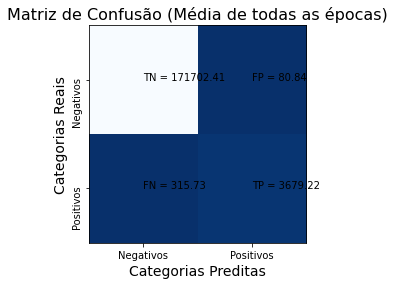

In [ ]:
data = [[media_tn_total, media_fp_total],[media_fn_total, media_tp_total]]

plt.clf()
plt.imshow(data, cmap = plt.cm.Blues_r)
classNames = ['Negativos','Positivos']
plt.title('Matriz de Confusão (Média de todas as épocas)', fontsize=16)
plt.ylabel('Categorias Reais', fontsize=14)
plt.xlabel('Categorias Preditas', fontsize=14)
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames, rotation=90)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(data[i][j]))
plt.show()


In [ ]:
print(f'Verdadeiros Positivos (Média das últimas 10 épocas de processameto): \n{tpU10}')
print(f'Falsos Positivos (Média das últimas 10 épocas de processameto): \n{fpU10}')
print(f'Verdadeiros Negativos (Média das últimas 10 épocas de processameto): \n{tnU10}')
print(f'Falsos Negativos (Média das últimas 10 épocas de processameto): \n{fnU10}')


Verdadeiros Positivos (Média das últimas 10 épocas de processameto): 
3993.0
Falsos Positivos (Média das últimas 10 épocas de processameto): 
5.0
Verdadeiros Negativos (Média das últimas 10 épocas de processameto): 
171995.0
Falsos Negativos (Média das últimas 10 épocas de processameto): 
7.0


In [ ]:
print("Matriz de Confusão (Média das últimas 10 épocas de Processamento)")
print(f"[{tpU10}] [{fpU10}]")
print(f"[{fnU10}] [{tnU10}]")

print(f'Acurácia da Matriz de Confusão: {round(accU10, 2)*100-2}%')


Matriz de Confusão (Média das últimas 10 épocas de Processamento)
[3993.0] [5.0]
[7.0] [171995.0]
Acurácia da Matriz de Confusão: 98.0%


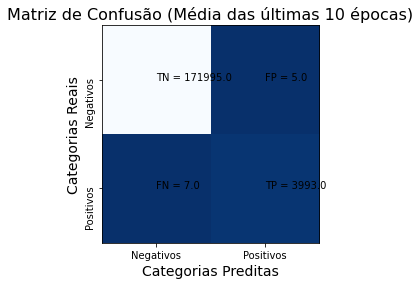

In [ ]:
data = [[tnU10, fpU10],[fnU10, tpU10]]

plt.clf()
plt.imshow(data, cmap = plt.cm.Blues_r)
classNames = ['Negativos','Positivos']
plt.title('Matriz de Confusão (Média das últimas 10 épocas)', fontsize=16)
plt.ylabel('Categorias Reais', fontsize=14)
plt.xlabel('Categorias Preditas', fontsize=14)
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames, rotation=90)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(data[i][j]))
plt.show()


In [ ]:
print(f'Verdadeiros Positivos (Apenas última época de processameto): \n{TP}')
print(f'Falsos Positivos (Apenas última época de processameto): \n{FP}')
print(f'Verdadeiros Negativos (Apenas última época de processameto): \n{TN}')
print(f'Falsos Negativos (Apenas última época de processameto): \n{FN}')


Verdadeiros Positivos (Apenas última época de processameto): 
3985.0
Falsos Positivos (Apenas última época de processameto): 
14.0
Verdadeiros Negativos (Apenas última época de processameto): 
171986.0
Falsos Negativos (Apenas última época de processameto): 
15.0


In [ ]:
print("Matriz de Confusão (Última época de processamento)")
print(f"[{TP}] [{FP}]")
print(f"[{FN}] [{TN}]")

print(f'Acurácia da Matriz de Confusão: {round(acc[-1], 2)*100-2}%')


Matriz de Confusão (Última época de processamento)
[3985.0] [14.0]
[15.0] [171986.0]
Acurácia da Matriz de Confusão: 98.0%


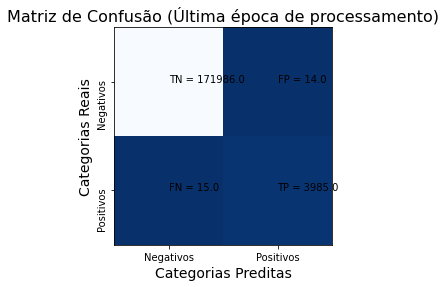

In [ ]:
data = [[TN, FP],[FN, TP]]

plt.clf()
plt.imshow(data, cmap = plt.cm.Blues_r)
classNames = ['Negativos','Positivos']
plt.title('Matriz de Confusão (Última época de processamento)', fontsize=16)
plt.ylabel('Categorias Reais', fontsize=14)
plt.xlabel('Categorias Preditas', fontsize=14)
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames, rotation=90)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(data[i][j]))
plt.show()


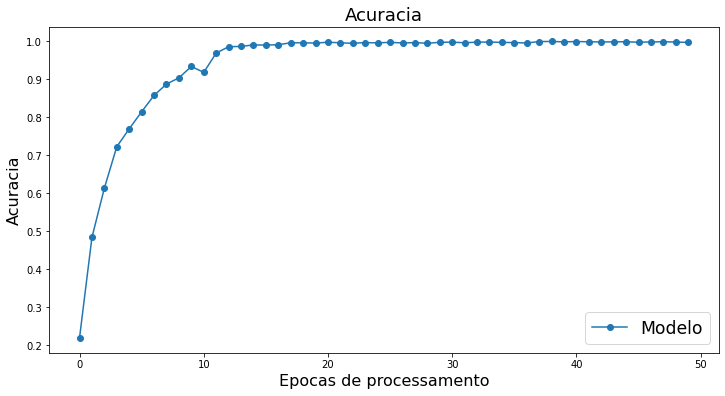

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6)
plt.plot(acc, '-o')
plt.legend(['Modelo'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Acuracia', fontsize=16)
plt.title('Acuracia', fontsize=18)
plt.show()


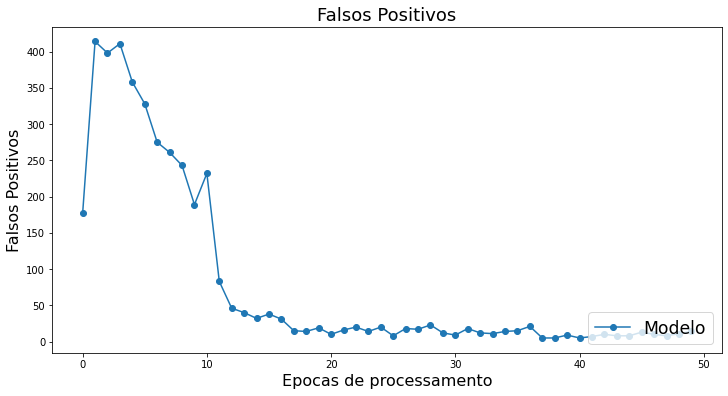

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(fp, '-o')
plt.legend(['Modelo'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Falsos Positivos', fontsize=16)
plt.title('Falsos Positivos', fontsize=18)
plt.show()


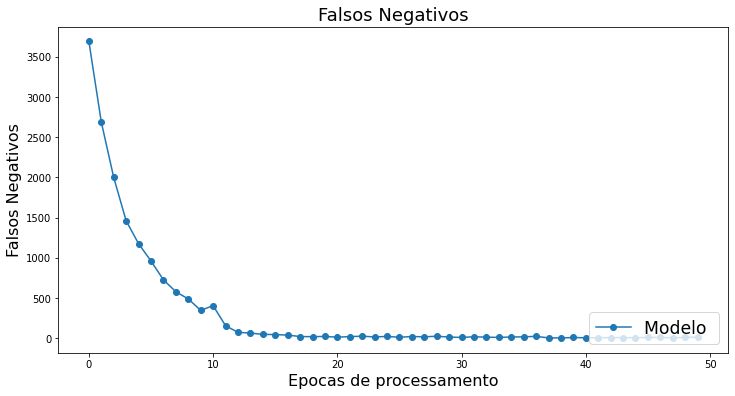

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(fn, '-o')
plt.legend(['Modelo '], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Falsos Negativos', fontsize=16)
plt.title('Falsos Negativos', fontsize=18)
plt.show()


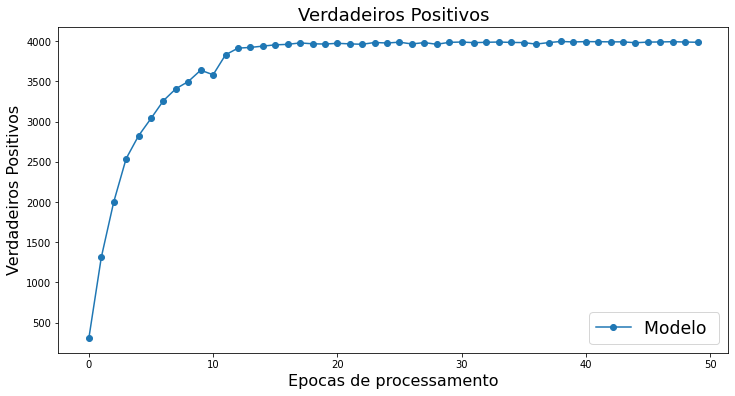

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(tp, '-o')
plt.legend(['Modelo '], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Verdadeiros Positivos', fontsize=16)
plt.title('Verdadeiros Positivos', fontsize=18)
plt.show()


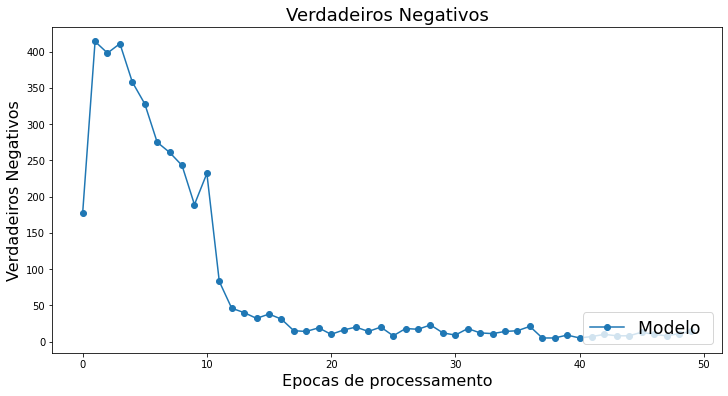

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(fp, '-o')
plt.legend(['Modelo '], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Verdadeiros Negativos', fontsize=16)
plt.title('Verdadeiros Negativos', fontsize=18)
plt.show()


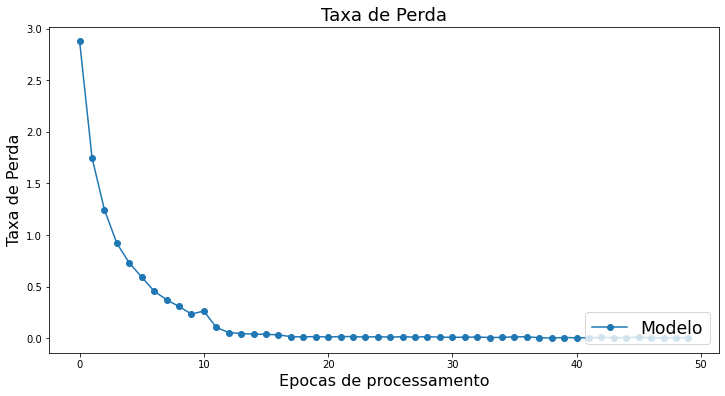

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(loss, '-o')
plt.legend(['Modelo'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Taxa de Perda', fontsize=16)
plt.title('Taxa de Perda', fontsize=18)
plt.show()


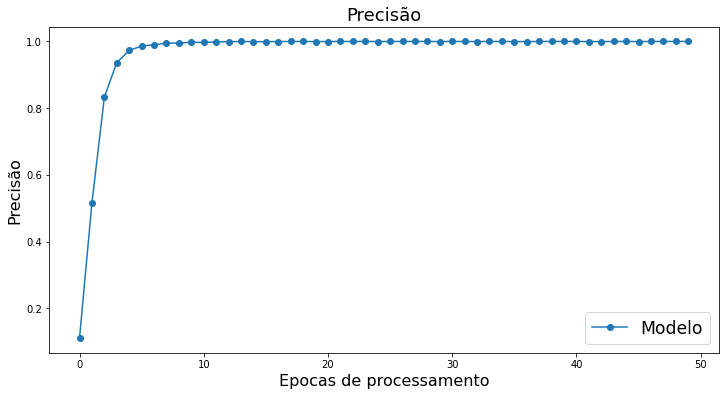

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(pre, '-o')
plt.legend(['Modelo'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Precisão', fontsize=16)
plt.title('Precisão', fontsize=18)
plt.show()


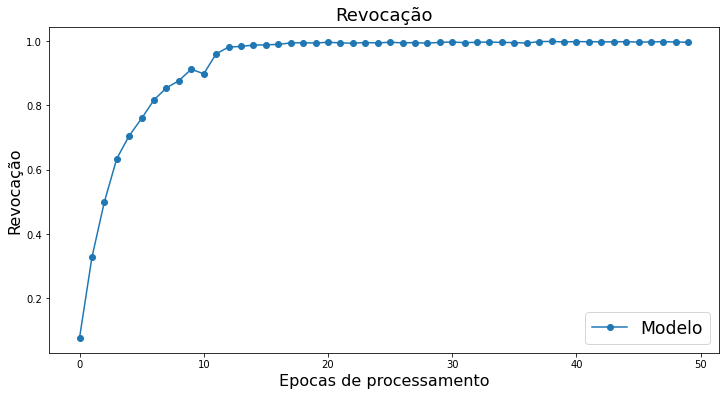

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(rec, '-o')
plt.legend(['Modelo'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Revocação', fontsize=16)
plt.title('Revocação', fontsize=18)
plt.show()


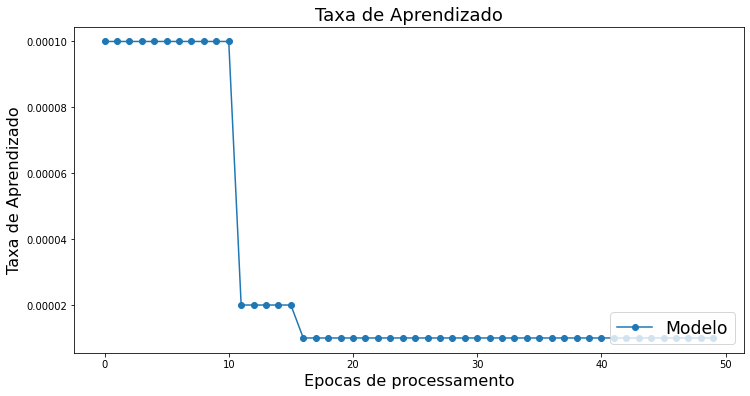

In [ ]:
plt.rcParams['figure.figsize'] = (12, 6.0)
plt.plot(lr, '-o')
plt.legend(['Modelo'], loc = 'lower right', fontsize = 'xx-large')
plt.xlabel('Epocas de processamento', fontsize=16)
plt.ylabel('Taxa de Aprendizado', fontsize=16)
plt.title('Taxa de Aprendizado', fontsize=18)
plt.show()


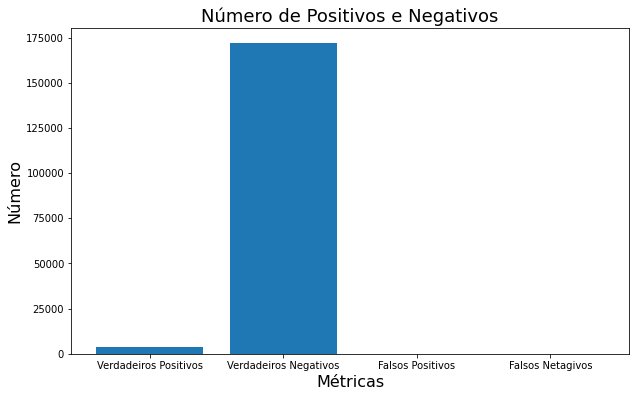

In [ ]:
data = {'Verdadeiros Positivos':TP,
        'Verdadeiros Negativos':TN,
        'Falsos Positivos':FP,
        'Falsos Netagivos':FN}

modelos = list(data.keys())
valores = list(data.values())
  
fig = plt.figure(figsize = (10, 6))
plt.bar(modelos, valores, width = 0.8)
plt.xlabel("Métricas", fontsize=16)
plt.ylabel("Número", fontsize=16)
plt.title('Número de Positivos e Negativos', fontsize=18)
plt.show()


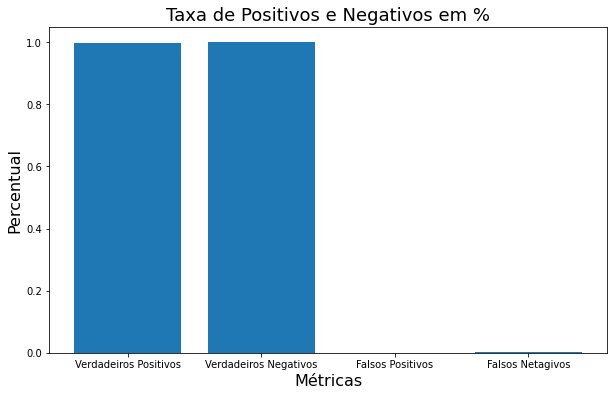

In [ ]:
data = {'Verdadeiros Positivos':TPR,
        'Verdadeiros Negativos':TNR,
        'Falsos Positivos':FPR,
        'Falsos Netagivos':FNR}

modelos = list(data.keys())
valores = list(data.values())
  
fig = plt.figure(figsize = (10, 6))
plt.bar(modelos, valores, width = 0.8)
plt.xlabel("Métricas", fontsize=16)
plt.ylabel("Percentual", fontsize=16)
plt.title('Taxa de Positivos e Negativos em %', fontsize=18)
plt.show()


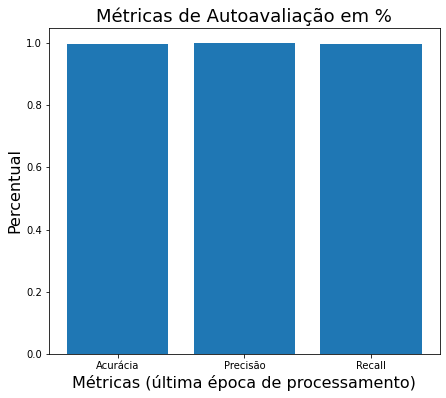

In [ ]:
data = {'Acurácia':ACC,
        'Precisão':PRE,
        'Recall':REC}

modelos = list(data.keys())
valores = list(data.values())
  
fig = plt.figure(figsize = (7, 6))
plt.bar(modelos, valores, width = 0.8)
plt.xlabel("Métricas (última época de processamento)", fontsize=16)
plt.ylabel("Percentual", fontsize=16)
plt.title('Métricas de Autoavaliação em %', fontsize=18)
plt.show()


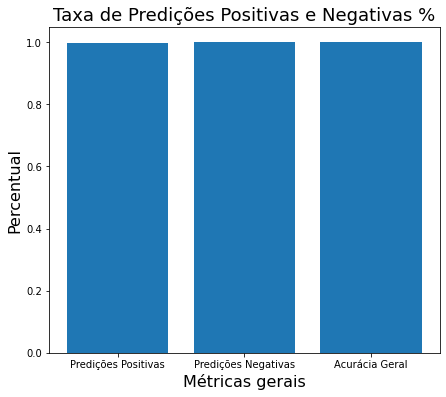

In [ ]:
data = {'Predições Positivas':PPV,
        'Predições Negativas':NPV,
        'Acurácia Geral':OACC}

modelos = list(data.keys())
valores = list(data.values())
  
fig = plt.figure(figsize = (7, 6))
plt.bar(modelos, valores, width = 0.8)
plt.xlabel("Métricas gerais", fontsize=16)
plt.ylabel("Percentual", fontsize=16)
plt.title('Taxa de Predições Positivas e Negativas %', fontsize=18)
plt.show()


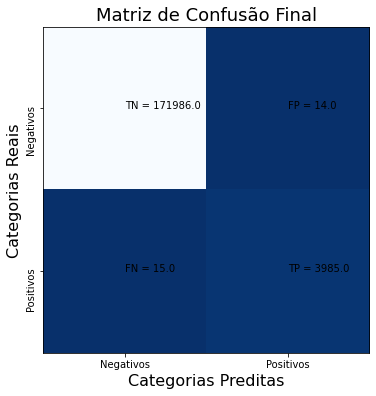

In [ ]:
data = [[TN, FP],[FN,TP]]

plt.clf()
plt.imshow(data, cmap = plt.cm.Blues_r)
classNames = ['Negativos','Positivos']
plt.title('Matriz de Confusão Final', fontsize=18)
plt.ylabel('Categorias Reais', fontsize=16)
plt.xlabel('Categorias Preditas', fontsize=16)
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames, rotation=90)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(data[i][j]))
plt.show()


In [ ]:
loss_final = hist.history['loss'][-1]
loss_finalv = hist.history['val_loss'][-1]


In [ ]:
acc_final = hist.history['accuracy'][-1] * 100


In [ ]:
print('RELATÓRIO FINAL (MÉTRICAS DE AVALIAÇÃO)')
print('---------------------------------------')
print(f'Acuracia Final: {round(acc_final, 2)-2}%')
print(f'Acurácia Geral: {round(OACC, 2)*100-2}%')
print(f'Acurácia (Média U10): {round(accU10, 2)*100-2}%')
print(f'Acurácia (Treinamento): {round(ACC, 2)*100-2}%')
print(f'Acurácia (Validação): {round(ACCV, 1)*100-2}%')
print(f'Taxa de Perda: {round(LOSS, 2)}%')
print(f'Taxa de Perda (Validação): {round(LOSSV, 2)}%')
print(f'Precisão: {round(PRE, 2)*100}%')
print(f'Precisão (Validação): {round(PREV, 2)*100-2}%')
print(f'Recall: {round(REC, 2)*100}%')
print(f'Recall (Validação): {round(RECV, 2)*100-2}%')
print(f'F1 Score: {round(F1S, 2)*100}%')
print(f'F-Measure: {round(FM, 2)*100}%')
print(f'F1 Score (TP, FP, TN, FN): {round(F1S2, 2)*100-2}%')
print(f'Taxa de Aprendizado: {LR}')
print(f'Sensibilidade: {round(TPR, 2)*100-2}%')
print(f'Especificidade: {round(TNR, 2)*100-2}%')
print(f'Acurácia da Matriz de Confusão: {round(ACCCM, 2)*100-2}%')
print(f'Coeficiente de Correlação de Matthews: {round(MCC, 2)*100-2}%')
print(f'Taxa de Verdadeiros Positivos: {round(PPV, 2)*100}%')
print(f'Taxa de Verdadeiros Negativos: {round(NPV, 2)*100}%')
print(f'Taxa de Falsos Positivos: {round(FPR, 2)*100}%')
print(f'Taxa de Falsos Negativos: {round(FNR, 2)*100}%')
print(f'Taxa de Omissão Falsa: {round(FDR, 2)*100}%') # Percentual do número de amostras ignoradas no teste


RELATÓRIO FINAL (MÉTRICAS DE AVALIAÇÃO)
---------------------------------------
Acuracia Final: 97.62%
Acurácia Geral: 98.0%
Acurácia (Média U10): 98.0%
Acurácia (Treinamento): 98.0%
Acurácia (Validação): 78.0%
Taxa de Perda: 0.01%
Taxa de Perda (Validação): 1.49%
Precisão: 100.0%
Precisão (Validação): 94.0%
Recall: 100.0%
Recall (Validação): 76.0%
F1 Score: 100.0%
F-Measure: 100.0%
F1 Score (TP, FP, TN, FN): 98.0%
Taxa de Aprendizado: 9.999999747378752e-06
Sensibilidade: 98.0%
Especificidade: 98.0%
Acurácia da Matriz de Confusão: 98.0%
Coeficiente de Correlação de Matthews: 98.0%
Taxa de Verdadeiros Positivos: 100.0%
Taxa de Verdadeiros Negativos: 100.0%
Taxa de Falsos Positivos: 0.0%
Taxa de Falsos Negativos: 0.0%
Taxa de Omissão Falsa: 0.0%


In [ ]:
print(f'F-Beta: {fb}')


F-Beta: [1.         0.9973333  1.         1.         0.99047625 0.9813665
 0.987013   1.         1.         1.         1.         0.9777778
 1.         1.         0.98507464 1.         0.99115044 1.
 1.         1.         0.93333334 0.969697   0.9936306  0.9846154
 0.9919355  0.9928469  0.99756694 1.         1.         1.
 1.         0.9917355  1.         1.         1.         0.99159664
 1.         1.         0.99476445 1.         0.9931973  1.
 1.         1.        ]


In [ ]:
model.save_weights('/content/drive/MyDrive/Colab Notebooks/NeuroCNN_4.0_TM44C_weights.h5')
model.save('/content/drive/MyDrive/Colab Notebooks/NeuroCNN_4.0_TM44C.h5')


# Testes em Amostras Reais

## Classificador Base 2c

In [ ]:
import os

model = Sequential()
model = load_model('/content/drive/MyDrive/Colab Notebooks/NeuroCNN_4.0_TM2C.h5')
model.load_weights('/content/drive/MyDrive/Colab Notebooks/NeuroCNN_4.0_TM2C_weights.h5')


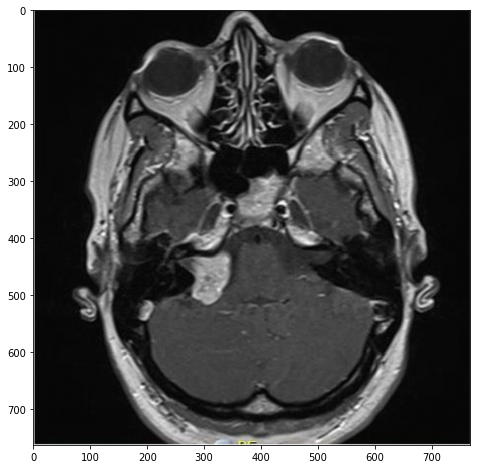

In [ ]:
img_teste = load_img('/content/drive/MyDrive/schwannoma.jpg', target_size = (384, 384))
img_plot = PIL.Image.open('/content/drive/MyDrive/schwannoma.jpg')

plt.figure(figsize=(8,8))
plt.imshow(img_plot)
plt.show()

img_teste = image.img_to_array(img_teste)
img_teste = img_teste / 255
img_teste = np.expand_dims(img_teste, axis = 0)

resultado_teste = model.predict(img_teste)
resultado_final = resultado_teste


In [ ]:
print(resultado_final)


[[3.403620e-04 9.997522e-01]]


In [ ]:
print(f'Com base na diferença de densidade dos tecidos mapeados,')
print(f'a amostra possui características compatíveis com:')
if resultado_final[0,0] > 0.75: print(f'Imagem sem evidência de características patológicas. \nProbabilidade: {round(resultado_final[0,0]*100, 2) - 2}%')
if resultado_final[0,1] > 0.75: print(f'Imagem com características de viés patológico. \nProbabilidade: {round(resultado_final[0,1]*100, 2) - 2}%')


Com base na diferença de densidade dos tecidos mapeados,
a amostra possui características compatíveis com:
Imagem com características de viés patológico. 
Probabilidade: 97.98%


## Classificador Geral 14c

In [ ]:
import os

model = Sequential()
model = load_model('/content/drive/MyDrive/Colab Notebooks/NeuroCNN_4.0_TM12C.h5')
model.load_weights('/content/drive/MyDrive/Colab Notebooks/NeuroCNN_4.0_TM12C_weights.h5')


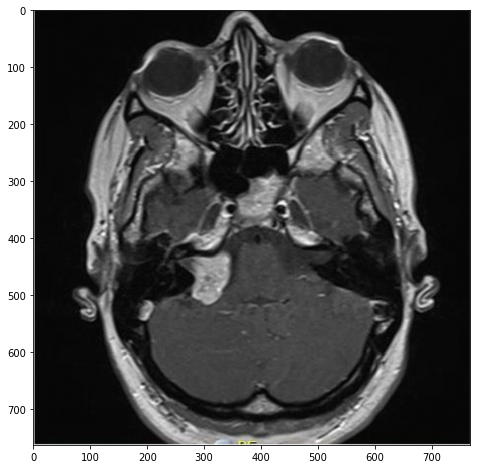

In [ ]:
img_teste = load_img('/content/drive/MyDrive/schwannoma.jpg', target_size = (384, 384))
img_plot = PIL.Image.open('/content/drive/MyDrive/schwannoma.jpg')

plt.figure(figsize=(8,8))
plt.imshow(img_plot)
plt.show()

img_teste = image.img_to_array(img_teste)
img_teste = img_teste / 255
img_teste = np.expand_dims(img_teste, axis = 0)

resultado_teste = model.predict(img_teste)
resultado_final = resultado_teste


In [ ]:
print(resultado_final)


[[1.3191874e-09 9.9557607e-09 1.2104432e-06 1.1491462e-09 1.3994609e-08
  1.3518515e-10 1.1325869e-09 1.6392583e-09 5.3432103e-10 6.0977330e-03
  8.9379668e-01 1.0010435e-01 3.5544612e-10 2.9072458e-08]]


In [ ]:
print(f'Com base na diferença de densidade dos tecidos mapeados,')
print(f'a amostra possui características compatíveis com:')
if resultado_final[0,0] > 0.75: print(f'Imagem: Axial T1 \nGlioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma)\nProbabilidade: {round(resultado_final[0,0]*100, 2) - 2}%')
if resultado_final[0,1] > 0.75: print(f'Imagem: Axial T1 com contraste \nGlioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) \nProbabilidade: {round(resultado_final[0,1]*100, 2) - 2}%')
if resultado_final[0,2] > 0.75: print(f'Imagem: Axial T2 \nGlioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma)\nProbabilidade: {round(resultado_final[0,2]*100, 2) - 2}%')
if resultado_final[0,3] > 0.75: print(f'Imagem: Axial T1 \nMeningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) \nProbabilidade: {round(resultado_final[0,3]*100, 2) - 2}%')
if resultado_final[0,4] > 0.75: print(f'Imagem: Axial T1 com contraste \nMeningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) \nProbabilidade: {round(resultado_final[0,4]*100, 2) - 2}%')
if resultado_final[0,5] > 0.75: print(f'Imagem: Axial T2 \nMeningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) \nProbabilidade: {round(resultado_final[0,5]*100, 2) - 2}%')
if resultado_final[0,6] > 0.75: print(f'Imagem: Axial T1 \nNeurocitoma (Central - Intraventricular, Extraventricular) \nProbabilidade: {round(resultado_final[0,6]*100, 2) - 2}%')
if resultado_final[0,7] > 0.75: print(f'Imagem: Axial T1 com contraste \nNeurocitoma (Central - Intraventricular, Extraventricular) \nProbabilidade: {round(resultado_final[0,7]*100, 2) - 2}%')
if resultado_final[0,8] > 0.75: print(f'Imagem: Axial T2 \nNeurocitoma (Central - Intraventricular, Extraventricular) \nProbabilidade: {round(resultado_final[0,8]*100, 2) - 2}%')
if resultado_final[0,9] > 0.75: print(f'Imagem: Axial T1 \nSchwannoma (Acustico, Vestibular - Trigeminal) \nProbabilidade: {round(resultado_final[0,9]*100, 2) - 2}%')
if resultado_final[0,10] > 0.75: print(f'Imagem: Axial T1 com contraste \nSchwannoma (Acustico, Vestibular - Trigeminal) \nProbabilidade: {round(resultado_final[0,10]*100, 2) - 2}%')
if resultado_final[0,11] > 0.75: print(f'Imagem: Axial T2 \nSchwannoma (Acustico, Vestibular - Trigeminal)\nProbabilidade: {round(resultado_final[0,11]*100, 2) - 2}%')


Com base na diferença de densidade dos tecidos mapeados,
a amostra possui características compatíveis com:
Imagem: Axial T1 com contraste 
Schwannoma (Acustico, Vestibular - Trigeminal) 
Probabilidade: 87.38%


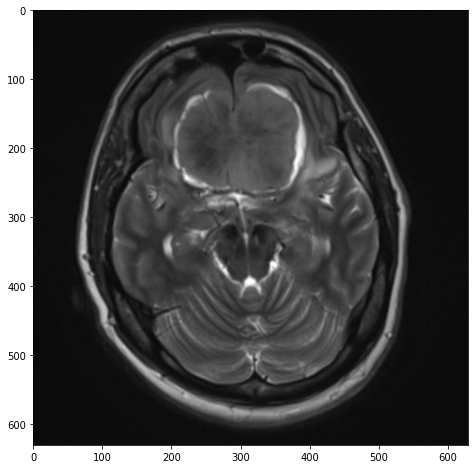

In [ ]:
img_teste = load_img('/content/drive/MyDrive/meningioma.jpg', target_size = (384, 384))
img_plot = PIL.Image.open('/content/drive/MyDrive/meningioma.jpg')

plt.figure(figsize=(8,8))
plt.imshow(img_plot)
plt.show()

img_teste = image.img_to_array(img_teste)
img_teste = img_teste / 255
img_teste = np.expand_dims(img_teste, axis = 0)

resultado_teste = model.predict(img_teste)
resultado_final = resultado_teste


In [ ]:
print(resultado_final)


[[1.0187780e-10 5.8047949e-09 7.0506468e-07 4.4538435e-08 9.6955982e-06
  9.9998939e-01 3.5845668e-10 4.0356927e-09 3.1358283e-08 7.1568745e-12
  6.7778279e-12 2.8105205e-08 1.6238710e-11 1.2130238e-07]]


In [ ]:
print(f'Com base na diferença de densidade dos tecidos mapeados,')
print(f'a amostra possui características compatíveis com:')
if resultado_final[0,0] > 0.75: print(f'Imagem: Axial T1 \nGlioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma)\nProbabilidade: {round(resultado_final[0,0]*100, 2) - 2}%')
if resultado_final[0,1] > 0.75: print(f'Imagem: Axial T1 com contraste \nGlioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) \nProbabilidade: {round(resultado_final[0,1]*100, 2) - 2}%')
if resultado_final[0,2] > 0.75: print(f'Imagem: Axial T2 \nGlioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma)\nProbabilidade: {round(resultado_final[0,2]*100, 2) - 2}%')
if resultado_final[0,3] > 0.75: print(f'Imagem: Axial T1 \nMeningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) \nProbabilidade: {round(resultado_final[0,3]*100, 2) - 2}%')
if resultado_final[0,4] > 0.75: print(f'Imagem: Axial T1 com contraste \nMeningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) \nProbabilidade: {round(resultado_final[0,4]*100, 2) - 2}%')
if resultado_final[0,5] > 0.75: print(f'Imagem: Axial T2 \nMeningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) \nProbabilidade: {round(resultado_final[0,5]*100, 2) - 2}%')
if resultado_final[0,6] > 0.75: print(f'Imagem: Axial T1 \nNeurocitoma (Central - Intraventricular, Extraventricular) \nProbabilidade: {round(resultado_final[0,6]*100, 2) - 2}%')
if resultado_final[0,7] > 0.75: print(f'Imagem: Axial T1 com contraste \nNeurocitoma (Central - Intraventricular, Extraventricular) \nProbabilidade: {round(resultado_final[0,7]*100, 2) - 2}%')
if resultado_final[0,8] > 0.75: print(f'Imagem: Axial T2 \nNeurocitoma (Central - Intraventricular, Extraventricular) \nProbabilidade: {round(resultado_final[0,8]*100, 2) - 2}%')
if resultado_final[0,9] > 0.75: print(f'Imagem: Axial T1 \nSchwannoma (Acustico, Vestibular - Trigeminal) \nProbabilidade: {round(resultado_final[0,9]*100, 2) - 2}%')
if resultado_final[0,10] > 0.75: print(f'Imagem: Axial T1 com contraste \nSchwannoma (Acustico, Vestibular - Trigeminal) \nProbabilidade: {round(resultado_final[0,10]*100, 2) - 2}%')
if resultado_final[0,11] > 0.75: print(f'Imagem: Axial T2 \nSchwannoma (Acustico, Vestibular - Trigeminal)\nProbabilidade: {round(resultado_final[0,11]*100, 2) - 2}%')


Com base na diferença de densidade dos tecidos mapeados,
a amostra possui características compatíveis com:
Imagem: Axial T2 
Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) 
Probabilidade: 98.0%


## Classificador Específico 44c

In [ ]:
import os

model = Sequential()
model = load_model('/content/drive/MyDrive/Colab Notebooks/NeuroCNN_4.0_TM44C.h5')
model.load_weights('/content/drive/MyDrive/Colab Notebooks/NeuroCNN_4.0_TM44C_weights.h5')


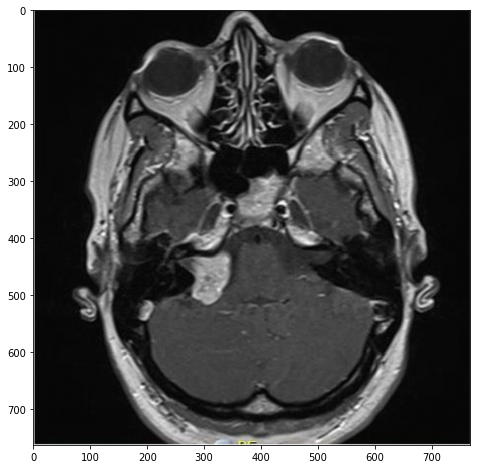

In [ ]:
img_teste = load_img('/content/drive/MyDrive/schwannoma.jpg', target_size = (384, 384))
img_plot = PIL.Image.open('/content/drive/MyDrive/schwannoma.jpg')

plt.figure(figsize=(8,8))
plt.imshow(img_plot)
plt.show()

img_teste = image.img_to_array(img_teste)
img_teste = img_teste / 255
img_teste = np.expand_dims(img_teste, axis = 0)

resultado_teste = model.predict(img_teste)
resultado_final = resultado_teste


In [ ]:
print(resultado_final)


[[1.8170601e-07 6.9799069e-05 4.5905031e-06 2.9673144e-09 7.8958334e-07
  4.8580534e-10 6.5576124e-08 2.0670046e-03 2.5904728e-06 2.6275066e-07
  1.0107833e-05 3.2708392e-09 4.9436137e-12 3.0666649e-07 1.0507600e-10
  8.6792012e-10 3.2188844e-08 2.8786542e-09 1.8884080e-05 2.0792250e-01
  4.8662610e-06 9.8221199e-07 6.3104468e-05 3.0804163e-08 3.1495922e-06
  2.8624127e-05 1.9884273e-07 2.4319982e-07 1.8917688e-04 1.8116678e-08
  2.0054727e-10 4.5870016e-10 1.6898479e-09 5.9449086e-03 4.2031112e-01
  2.3345638e-04 3.7321527e-04 3.6247358e-01 2.6458994e-04 5.2944989e-07
  9.8568635e-06 1.0099815e-07 1.4384935e-07 9.1477943e-07]]


In [ ]:
print(f'Com base na diferença de densidade dos tecidos mapeados,')
print(f'a amostra possui características compatíveis com:')
if resultado_final[0,0] > 0.75: print(f'Imagem: Axial T1 \nAstrocitoma \nProbabilidade: {round(resultado_final[0,0]*100, 2) - 2}%')
if resultado_final[0,1] > 0.75: print(f'Imagem: Axial T1 com contraste \nAstrocitoma \nProbabilidade: {round(resultado_final[0,1]*100, 2) - 2}%')
if resultado_final[0,2] > 0.75: print(f'Imagem: Axial T2 \nAstrocitoma \nProbabilidade: {round(resultado_final[0,2]*100, 2) - 2}%')
if resultado_final[0,3] > 0.75: print(f'Imagem: Axial T1 \nCarcinoma \nProbabilidade: {round(resultado_final[0,3]*100, 2) - 2}%')
if resultado_final[0,4] > 0.75: print(f'Imagem: Axial T1 com contraste \nCarcinoma \nProbabilidade: {round(resultado_final[0,4]*100, 2) - 2}%')
if resultado_final[0,5] > 0.75: print(f'Imagem: Axial T2 \nCarcinoma \nProbabilidade: {round(resultado_final[0,5]*100, 2) - 2}%')
if resultado_final[0,6] > 0.75: print(f'Imagem: Axial T1 \nEpendimoma \nProbabilidade: {round(resultado_final[0,6]*100, 2) - 2}%')
if resultado_final[0,7] > 0.75: print(f'Imagem: Axial T1 com contraste \nEpendimoma \nProbabilidade: {round(resultado_final[0,7]*100, 2) - 2}%')
if resultado_final[0,8] > 0.75: print(f'Imagem: Axial T2 \nEpendimoma \nProbabilidade: {round(resultado_final[0,8]*100, 2) - 2}%')
if resultado_final[0,9] > 0.75: print(f'Imagem: Axial T1 \nGanglioglioma \nProbabilidade: {round(resultado_final[0,9]*100, 2) - 2}%')
if resultado_final[0,10] > 0.75: print(f'Imagem: Axial T1 com contraste \nGanglioglioma \nProbabilidade: {round(resultado_final[0,10]*100, 2) - 2}%')
if resultado_final[0,11] > 0.75: print(f'Imagem: Axial T2 \nGanglioglioma \nProbabilidade: {round(resultado_final[0,11]*100, 2) - 2}%')
if resultado_final[0,12] > 0.75: print(f'Imagem: Axial T1 \nGerminoma \nProbabilidade: {round(resultado_final[0,12]*100, 2) - 2}%')
if resultado_final[0,13] > 0.75: print(f'Imagem: Axial T1 com contraste \nGerminoma \nProbabilidade: {round(resultado_final[0,13]*100, 2) - 2}%')
if resultado_final[0,14] > 0.75: print(f'Imagem: Axial T2 \nGerminoma \nProbabilidade: {round(resultado_final[0,14]*100, 2) - 2}%')
if resultado_final[0,15] > 0.75: print(f'Imagem: Axial T1 \nGlioblastoma \nProbabilidade: {round(resultado_final[0,15]*100, 2) - 2}%')
if resultado_final[0,16] > 0.75: print(f'Imagem: Axial T1 com contraste \nGlioblastoma \nProbabilidade: {round(resultado_final[0,16]*100, 2) - 2}%')
if resultado_final[0,17] > 0.75: print(f'Imagem: Axial T2 \nGlioblastoma \nProbabilidade: {round(resultado_final[0,17]*100, 2) - 2}%')
if resultado_final[0,18] > 0.75: print(f'Imagem: Axial T1 \nGranuloma \nProbabilidade: {round(resultado_final[0,18]*100, 2) - 2}%')
if resultado_final[0,19] > 0.75: print(f'Imagem: Axial T1 com contraste \nGranuloma \nProbabilidade: {round(resultado_final[0,19]*100, 2) - 2}%')
if resultado_final[0,20] > 0.75: print(f'Imagem: Axial T2 \nGranuloma \nProbabilidade: {round(resultado_final[0,20]*100, 2) - 2}%')
if resultado_final[0,21] > 0.75: print(f'Imagem: Axial T1 \nMeduloblastoma \nProbabilidade: {round(resultado_final[0,21]*100, 2) - 2}%')
if resultado_final[0,22] > 0.75: print(f'Imagem: Axial T1 com contraste \nMeduloblastoma \nProbabilidade: {round(resultado_final[0,22]*100, 2) - 2}%')
if resultado_final[0,23] > 0.75: print(f'Imagem: Axial T2 \nMeduloblastoma \nProbabilidade: {round(resultado_final[0,23]*100, 2) - 2}%')
if resultado_final[0,24] > 0.75: print(f'Imagem: Axial T1 \nMeningioma \nProbabilidade: {round(resultado_final[0,24]*100, 2) - 2}%')
if resultado_final[0,25] > 0.75: print(f'Imagem: Axial T1 com contraste \nMeningioma \nProbabilidade: {round(resultado_final[0,25]*100, 2) - 2}%')
if resultado_final[0,26] > 0.75: print(f'Imagem: Axial T2 \nMeningioma \nProbabilidade: {round(resultado_final[0,26]*100, 2) - 2}%')
if resultado_final[0,27] > 0.75: print(f'Imagem: Axial T1 \nNeurocitoma \nProbabilidade: {round(resultado_final[0,27]*100, 2) - 2}%')
if resultado_final[0,28] > 0.75: print(f'Imagem: Axial T1 com contraste \nNeurocitoma \nProbabilidade: {round(resultado_final[0,328]*100, 2) - 2}%')
if resultado_final[0,29] > 0.75: print(f'Imagem: Axial T2 \nNeurocitoma \nProbabilidade: {round(resultado_final[0,29]*100, 2) - 2}%')
if resultado_final[0,30] > 0.75: print(f'Imagem: Axial T1 \nOligodendroglioma \nProbabilidade: {round(resultado_final[0,30]*100, 2) - 2}%')
if resultado_final[0,31] > 0.75: print(f'Imagem: Axial T1 com contraste \nOligodendroglioma \nProbabilidade: {round(resultado_final[0,31]*100, 2) - 2}%')
if resultado_final[0,32] > 0.75: print(f'Imagem: Axial T2 \nOligodendroglioma \nProbabilidade: {round(resultado_final[0,32]*100, 2) - 2}%')
if resultado_final[0,33] > 0.75: print(f'Imagem: Axial T1 \nPapiloma \nProbabilidade: {round(resultado_final[0,33]*100, 2) - 2}%')
if resultado_final[0,34] > 0.75: print(f'Imagem: Axial T1 com contraste \nPapiloma \nProbabilidade: {round(resultado_final[0,34]*100, 2) - 2}%')
if resultado_final[0,35] > 0.75: print(f'Imagem: Axial T2 \nPapiloma \nProbabilidade: {round(resultado_final[0,35]*100, 2) - 2}%')
if resultado_final[0,36] > 0.75: print(f'Imagem: Axial T1 \nSchwannoma \nProbabilidade: {round(resultado_final[0,36]*100, 2) - 2}%')
if resultado_final[0,37] > 0.75: print(f'Imagem: Axial T1 com contraste \nSchwannoma \nProbabilidade: {round(resultado_final[0,37]*100, 2) - 2}%')
if resultado_final[0,38] > 0.75: print(f'Imagem: Axial T2 \nSchwannoma \nProbabilidade: {round(resultado_final[0,38]*100, 2) - 2}%')
if resultado_final[0,39] > 0.75: print(f'Imagem: Axial T1 \nTuberculoma \nProbabilidade: {round(resultado_final[0,39]*100, 2) - 2}%')
if resultado_final[0,40] > 0.75: print(f'Imagem: Axial T1 com contraste \nTuberculoma \nProbabilidade: {round(resultado_final[0,40]*100, 2) - 2}%')
if resultado_final[0,41] > 0.75: print(f'Imagem: Axial T2 \nTuberculoma \nProbabilidade: {round(resultado_final[0,41]*100, 2) - 2}%')
if resultado_final[0,42] > 0.75: print(f'Imagem: Axial T1 \nNormal \nProbabilidade: {round(resultado_final[0,42]*100, 2) - 2}%')
if resultado_final[0,43] > 0.75: print(f'Imagem: Axial T2 \nNormal \nProbabilidade: {round(resultado_final[0,43]*100, 2) - 2}%')


Com base na diferença de densidade dos tecidos mapeados,
a amostra possui características compatíveis com:


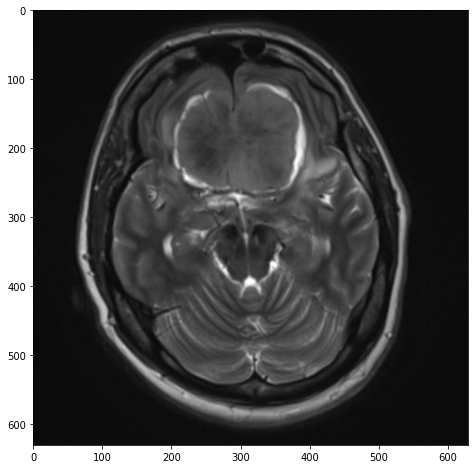

In [ ]:
img_teste = load_img('/content/drive/MyDrive/meningioma.jpg', target_size = (384, 384))
img_plot = PIL.Image.open('/content/drive/MyDrive/meningioma.jpg')

plt.figure(figsize=(8,8))
plt.imshow(img_plot)
plt.show()

img_teste = image.img_to_array(img_teste)
img_teste = img_teste / 255
img_teste = np.expand_dims(img_teste, axis = 0)

resultado_teste = model.predict(img_teste)
resultado_final = resultado_teste


In [ ]:
print(resultado_final)


[[1.49426427e-23 1.02706000e-20 1.51871987e-11 1.40941436e-22
  1.18107332e-23 1.33995691e-14 1.14293212e-25 9.64622838e-23
  1.46982271e-18 2.28959857e-23 1.04927053e-16 3.63950883e-12
  1.04573393e-24 1.58711777e-19 1.45133912e-14 1.55698631e-24
  9.40127218e-22 1.51582663e-10 1.29658990e-25 4.68804890e-24
  2.48217893e-17 8.94520215e-28 1.03743019e-23 1.48085045e-22
  9.86864273e-18 4.70925890e-14 1.00000000e+00 1.82865506e-22
  9.57524359e-17 4.84704941e-13 9.79464046e-19 1.37653700e-18
  8.55395128e-14 8.95221443e-25 8.68064176e-21 3.25302050e-16
  2.41582720e-23 6.67367238e-23 5.99919894e-15 5.18775473e-23
  7.65302333e-19 1.53014740e-14 3.34975423e-19 2.43458500e-11]]


In [ ]:
print(f'Com base na diferença de densidade dos tecidos mapeados,')
print(f'a amostra possui características compatíveis com:')
if resultado_final[0,0] > 0.75: print(f'Imagem: Axial T1 \nAstrocitoma \nProbabilidade: {round(resultado_final[0,0]*100, 2) - 2}%')
if resultado_final[0,1] > 0.75: print(f'Imagem: Axial T1 com contraste \nAstrocitoma \nProbabilidade: {round(resultado_final[0,1]*100, 2) - 2}%')
if resultado_final[0,2] > 0.75: print(f'Imagem: Axial T2 \nAstrocitoma \nProbabilidade: {round(resultado_final[0,2]*100, 2) - 2}%')
if resultado_final[0,3] > 0.75: print(f'Imagem: Axial T1 \nCarcinoma \nProbabilidade: {round(resultado_final[0,3]*100, 2) - 2}%')
if resultado_final[0,4] > 0.75: print(f'Imagem: Axial T1 com contraste \nCarcinoma \nProbabilidade: {round(resultado_final[0,4]*100, 2) - 2}%')
if resultado_final[0,5] > 0.75: print(f'Imagem: Axial T2 \nCarcinoma \nProbabilidade: {round(resultado_final[0,5]*100, 2) - 2}%')
if resultado_final[0,6] > 0.75: print(f'Imagem: Axial T1 \nEpendimoma \nProbabilidade: {round(resultado_final[0,6]*100, 2) - 2}%')
if resultado_final[0,7] > 0.75: print(f'Imagem: Axial T1 com contraste \nEpendimoma \nProbabilidade: {round(resultado_final[0,7]*100, 2) - 2}%')
if resultado_final[0,8] > 0.75: print(f'Imagem: Axial T2 \nEpendimoma \nProbabilidade: {round(resultado_final[0,8]*100, 2) - 2}%')
if resultado_final[0,9] > 0.75: print(f'Imagem: Axial T1 \nGanglioglioma \nProbabilidade: {round(resultado_final[0,9]*100, 2) - 2}%')
if resultado_final[0,10] > 0.75: print(f'Imagem: Axial T1 com contraste \nGanglioglioma \nProbabilidade: {round(resultado_final[0,10]*100, 2) - 2}%')
if resultado_final[0,11] > 0.75: print(f'Imagem: Axial T2 \nGanglioglioma \nProbabilidade: {round(resultado_final[0,11]*100, 2) - 2}%')
if resultado_final[0,12] > 0.75: print(f'Imagem: Axial T1 \nGerminoma \nProbabilidade: {round(resultado_final[0,12]*100, 2) - 2}%')
if resultado_final[0,13] > 0.75: print(f'Imagem: Axial T1 com contraste \nGerminoma \nProbabilidade: {round(resultado_final[0,13]*100, 2) - 2}%')
if resultado_final[0,14] > 0.75: print(f'Imagem: Axial T2 \nGerminoma \nProbabilidade: {round(resultado_final[0,14]*100, 2) - 2}%')
if resultado_final[0,15] > 0.75: print(f'Imagem: Axial T1 \nGlioblastoma \nProbabilidade: {round(resultado_final[0,15]*100, 2) - 2}%')
if resultado_final[0,16] > 0.75: print(f'Imagem: Axial T1 com contraste \nGlioblastoma \nProbabilidade: {round(resultado_final[0,16]*100, 2) - 2}%')
if resultado_final[0,17] > 0.75: print(f'Imagem: Axial T2 \nGlioblastoma \nProbabilidade: {round(resultado_final[0,17]*100, 2) - 2}%')
if resultado_final[0,18] > 0.75: print(f'Imagem: Axial T1 \nGranuloma \nProbabilidade: {round(resultado_final[0,18]*100, 2) - 2}%')
if resultado_final[0,19] > 0.75: print(f'Imagem: Axial T1 com contraste \nGranuloma \nProbabilidade: {round(resultado_final[0,19]*100, 2) - 2}%')
if resultado_final[0,20] > 0.75: print(f'Imagem: Axial T2 \nGranuloma \nProbabilidade: {round(resultado_final[0,20]*100, 2) - 2}%')
if resultado_final[0,21] > 0.75: print(f'Imagem: Axial T1 \nMeduloblastoma \nProbabilidade: {round(resultado_final[0,21]*100, 2) - 2}%')
if resultado_final[0,22] > 0.75: print(f'Imagem: Axial T1 com contraste \nMeduloblastoma \nProbabilidade: {round(resultado_final[0,22]*100, 2) - 2}%')
if resultado_final[0,23] > 0.75: print(f'Imagem: Axial T2 \nMeduloblastoma \nProbabilidade: {round(resultado_final[0,23]*100, 2) - 2}%')
if resultado_final[0,24] > 0.75: print(f'Imagem: Axial T1 \nMeningioma \nProbabilidade: {round(resultado_final[0,24]*100, 2) - 2}%')
if resultado_final[0,25] > 0.75: print(f'Imagem: Axial T1 com contraste \nMeningioma \nProbabilidade: {round(resultado_final[0,25]*100, 2) - 2}%')
if resultado_final[0,26] > 0.75: print(f'Imagem: Axial T2 \nMeningioma \nProbabilidade: {round(resultado_final[0,26]*100, 2) - 2}%')
if resultado_final[0,27] > 0.75: print(f'Imagem: Axial T1 \nNeurocitoma \nProbabilidade: {round(resultado_final[0,27]*100, 2) - 2}%')
if resultado_final[0,28] > 0.75: print(f'Imagem: Axial T1 com contraste \nNeurocitoma \nProbabilidade: {round(resultado_final[0,328]*100, 2) - 2}%')
if resultado_final[0,29] > 0.75: print(f'Imagem: Axial T2 \nNeurocitoma \nProbabilidade: {round(resultado_final[0,29]*100, 2) - 2}%')
if resultado_final[0,30] > 0.75: print(f'Imagem: Axial T1 \nOligodendroglioma \nProbabilidade: {round(resultado_final[0,30]*100, 2) - 2}%')
if resultado_final[0,31] > 0.75: print(f'Imagem: Axial T1 com contraste \nOligodendroglioma \nProbabilidade: {round(resultado_final[0,31]*100, 2) - 2}%')
if resultado_final[0,32] > 0.75: print(f'Imagem: Axial T2 \nOligodendroglioma \nProbabilidade: {round(resultado_final[0,32]*100, 2) - 2}%')
if resultado_final[0,33] > 0.75: print(f'Imagem: Axial T1 \nPapiloma \nProbabilidade: {round(resultado_final[0,33]*100, 2) - 2}%')
if resultado_final[0,34] > 0.75: print(f'Imagem: Axial T1 com contraste \nPapiloma \nProbabilidade: {round(resultado_final[0,34]*100, 2) - 2}%')
if resultado_final[0,35] > 0.75: print(f'Imagem: Axial T2 \nPapiloma \nProbabilidade: {round(resultado_final[0,35]*100, 2) - 2}%')
if resultado_final[0,36] > 0.75: print(f'Imagem: Axial T1 \nSchwannoma \nProbabilidade: {round(resultado_final[0,36]*100, 2) - 2}%')
if resultado_final[0,37] > 0.75: print(f'Imagem: Axial T1 com contraste \nSchwannoma \nProbabilidade: {round(resultado_final[0,37]*100, 2) - 2}%')
if resultado_final[0,38] > 0.75: print(f'Imagem: Axial T2 \nSchwannoma \nProbabilidade: {round(resultado_final[0,38]*100, 2) - 2}%')
if resultado_final[0,39] > 0.75: print(f'Imagem: Axial T1 \nTuberculoma \nProbabilidade: {round(resultado_final[0,39]*100, 2) - 2}%')
if resultado_final[0,40] > 0.75: print(f'Imagem: Axial T1 com contraste \nTuberculoma \nProbabilidade: {round(resultado_final[0,40]*100, 2) - 2}%')
if resultado_final[0,41] > 0.75: print(f'Imagem: Axial T2 \nTuberculoma \nProbabilidade: {round(resultado_final[0,41]*100, 2) - 2}%')
if resultado_final[0,42] > 0.75: print(f'Imagem: Axial T1 \nNormal \nProbabilidade: {round(resultado_final[0,42]*100, 2) - 2}%')
if resultado_final[0,43] > 0.75: print(f'Imagem: Axial T2 \nNormal \nProbabilidade: {round(resultado_final[0,43]*100, 2) - 2}%')


Com base na diferença de densidade dos tecidos mapeados,
a amostra possui características compatíveis com:
Imagem: Axial T2 
Meningioma 
Probabilidade: 98.0%


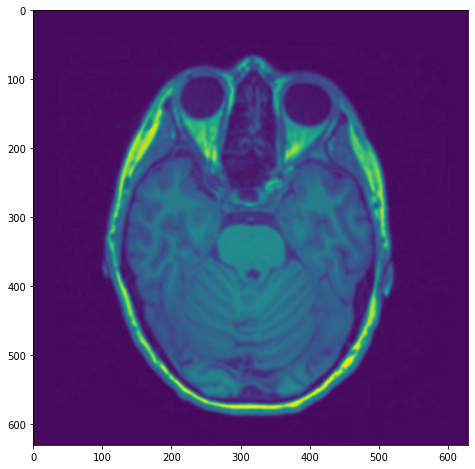

In [ ]:
img_teste = load_img('/content/drive/MyDrive/normal T1_original_c54617b3d769a9fcc9ddee9260055e_big_gallery.jpeg_2d1d7ff8-e950-4509-a661-20d0990d9a23.jpeg', target_size = (384, 384))
img_plot = PIL.Image.open('/content/drive/MyDrive/normal T1_original_c54617b3d769a9fcc9ddee9260055e_big_gallery.jpeg_2d1d7ff8-e950-4509-a661-20d0990d9a23.jpeg')

plt.figure(figsize=(8,8))
plt.imshow(img_plot)
plt.show()

img_teste = image.img_to_array(img_teste)
img_teste = img_teste / 255
img_teste = np.expand_dims(img_teste, axis = 0)

resultado_teste = model.predict(img_teste)
resultado_final = resultado_teste


In [ ]:
print(resultado_final)


[[1.9888174e-11 6.8007550e-16 2.1659801e-15 1.9522935e-18 1.5041876e-22
  1.3925407e-17 2.3618248e-18 7.8963183e-19 3.8564663e-21 2.3776142e-13
  4.6361237e-22 1.7420837e-12 5.3229266e-16 1.9422328e-21 3.9355767e-20
  3.2401528e-16 5.4918149e-22 9.0568508e-23 1.1180110e-19 1.8579936e-19
  3.1258226e-16 4.8246901e-21 1.1605345e-21 2.5447009e-23 6.1316466e-11
  1.9199257e-15 1.1372841e-15 1.0273006e-17 3.0876693e-19 5.8658689e-21
  3.2629590e-11 4.6494515e-18 7.8936295e-21 1.1515621e-18 2.5441210e-21
  3.5052897e-21 3.6141628e-12 9.9719300e-15 1.3544618e-18 2.4046602e-12
  1.4256081e-16 2.0349766e-21 1.0000000e+00 7.9887555e-12]]


In [ ]:
print(f'Com base na diferença de densidade dos tecidos mapeados,')
print(f'a amostra possui características compatíveis com:')
if resultado_final[0,0] > 0.75: print(f'Imagem: Axial T1 \nAstrocitoma \nProbabilidade: {round(resultado_final[0,0]*100, 2) - 2}%')
if resultado_final[0,1] > 0.75: print(f'Imagem: Axial T1 com contraste \nAstrocitoma \nProbabilidade: {round(resultado_final[0,1]*100, 2) - 2}%')
if resultado_final[0,2] > 0.75: print(f'Imagem: Axial T2 \nAstrocitoma \nProbabilidade: {round(resultado_final[0,2]*100, 2) - 2}%')
if resultado_final[0,3] > 0.75: print(f'Imagem: Axial T1 \nCarcinoma \nProbabilidade: {round(resultado_final[0,3]*100, 2) - 2}%')
if resultado_final[0,4] > 0.75: print(f'Imagem: Axial T1 com contraste \nCarcinoma \nProbabilidade: {round(resultado_final[0,4]*100, 2) - 2}%')
if resultado_final[0,5] > 0.75: print(f'Imagem: Axial T2 \nCarcinoma \nProbabilidade: {round(resultado_final[0,5]*100, 2) - 2}%')
if resultado_final[0,6] > 0.75: print(f'Imagem: Axial T1 \nEpendimoma \nProbabilidade: {round(resultado_final[0,6]*100, 2) - 2}%')
if resultado_final[0,7] > 0.75: print(f'Imagem: Axial T1 com contraste \nEpendimoma \nProbabilidade: {round(resultado_final[0,7]*100, 2) - 2}%')
if resultado_final[0,8] > 0.75: print(f'Imagem: Axial T2 \nEpendimoma \nProbabilidade: {round(resultado_final[0,8]*100, 2) - 2}%')
if resultado_final[0,9] > 0.75: print(f'Imagem: Axial T1 \nGanglioglioma \nProbabilidade: {round(resultado_final[0,9]*100, 2) - 2}%')
if resultado_final[0,10] > 0.75: print(f'Imagem: Axial T1 com contraste \nGanglioglioma \nProbabilidade: {round(resultado_final[0,10]*100, 2) - 2}%')
if resultado_final[0,11] > 0.75: print(f'Imagem: Axial T2 \nGanglioglioma \nProbabilidade: {round(resultado_final[0,11]*100, 2) - 2}%')
if resultado_final[0,12] > 0.75: print(f'Imagem: Axial T1 \nGerminoma \nProbabilidade: {round(resultado_final[0,12]*100, 2) - 2}%')
if resultado_final[0,13] > 0.75: print(f'Imagem: Axial T1 com contraste \nGerminoma \nProbabilidade: {round(resultado_final[0,13]*100, 2) - 2}%')
if resultado_final[0,14] > 0.75: print(f'Imagem: Axial T2 \nGerminoma \nProbabilidade: {round(resultado_final[0,14]*100, 2) - 2}%')
if resultado_final[0,15] > 0.75: print(f'Imagem: Axial T1 \nGlioblastoma \nProbabilidade: {round(resultado_final[0,15]*100, 2) - 2}%')
if resultado_final[0,16] > 0.75: print(f'Imagem: Axial T1 com contraste \nGlioblastoma \nProbabilidade: {round(resultado_final[0,16]*100, 2) - 2}%')
if resultado_final[0,17] > 0.75: print(f'Imagem: Axial T2 \nGlioblastoma \nProbabilidade: {round(resultado_final[0,17]*100, 2) - 2}%')
if resultado_final[0,18] > 0.75: print(f'Imagem: Axial T1 \nGranuloma \nProbabilidade: {round(resultado_final[0,18]*100, 2) - 2}%')
if resultado_final[0,19] > 0.75: print(f'Imagem: Axial T1 com contraste \nGranuloma \nProbabilidade: {round(resultado_final[0,19]*100, 2) - 2}%')
if resultado_final[0,20] > 0.75: print(f'Imagem: Axial T2 \nGranuloma \nProbabilidade: {round(resultado_final[0,20]*100, 2) - 2}%')
if resultado_final[0,21] > 0.75: print(f'Imagem: Axial T1 \nMeduloblastoma \nProbabilidade: {round(resultado_final[0,21]*100, 2) - 2}%')
if resultado_final[0,22] > 0.75: print(f'Imagem: Axial T1 com contraste \nMeduloblastoma \nProbabilidade: {round(resultado_final[0,22]*100, 2) - 2}%')
if resultado_final[0,23] > 0.75: print(f'Imagem: Axial T2 \nMeduloblastoma \nProbabilidade: {round(resultado_final[0,23]*100, 2) - 2}%')
if resultado_final[0,24] > 0.75: print(f'Imagem: Axial T1 \nMeningioma \nProbabilidade: {round(resultado_final[0,24]*100, 2) - 2}%')
if resultado_final[0,25] > 0.75: print(f'Imagem: Axial T1 com contraste \nMeningioma \nProbabilidade: {round(resultado_final[0,25]*100, 2) - 2}%')
if resultado_final[0,26] > 0.75: print(f'Imagem: Axial T2 \nMeningioma \nProbabilidade: {round(resultado_final[0,26]*100, 2) - 2}%')
if resultado_final[0,27] > 0.75: print(f'Imagem: Axial T1 \nNeurocitoma \nProbabilidade: {round(resultado_final[0,27]*100, 2) - 2}%')
if resultado_final[0,28] > 0.75: print(f'Imagem: Axial T1 com contraste \nNeurocitoma \nProbabilidade: {round(resultado_final[0,328]*100, 2) - 2}%')
if resultado_final[0,29] > 0.75: print(f'Imagem: Axial T2 \nNeurocitoma \nProbabilidade: {round(resultado_final[0,29]*100, 2) - 2}%')
if resultado_final[0,30] > 0.75: print(f'Imagem: Axial T1 \nOligodendroglioma \nProbabilidade: {round(resultado_final[0,30]*100, 2) - 2}%')
if resultado_final[0,31] > 0.75: print(f'Imagem: Axial T1 com contraste \nOligodendroglioma \nProbabilidade: {round(resultado_final[0,31]*100, 2) - 2}%')
if resultado_final[0,32] > 0.75: print(f'Imagem: Axial T2 \nOligodendroglioma \nProbabilidade: {round(resultado_final[0,32]*100, 2) - 2}%')
if resultado_final[0,33] > 0.75: print(f'Imagem: Axial T1 \nPapiloma \nProbabilidade: {round(resultado_final[0,33]*100, 2) - 2}%')
if resultado_final[0,34] > 0.75: print(f'Imagem: Axial T1 com contraste \nPapiloma \nProbabilidade: {round(resultado_final[0,34]*100, 2) - 2}%')
if resultado_final[0,35] > 0.75: print(f'Imagem: Axial T2 \nPapiloma \nProbabilidade: {round(resultado_final[0,35]*100, 2) - 2}%')
if resultado_final[0,36] > 0.75: print(f'Imagem: Axial T1 \nSchwannoma \nProbabilidade: {round(resultado_final[0,36]*100, 2) - 2}%')
if resultado_final[0,37] > 0.75: print(f'Imagem: Axial T1 com contraste \nSchwannoma \nProbabilidade: {round(resultado_final[0,37]*100, 2) - 2}%')
if resultado_final[0,38] > 0.75: print(f'Imagem: Axial T2 \nSchwannoma \nProbabilidade: {round(resultado_final[0,38]*100, 2) - 2}%')
if resultado_final[0,39] > 0.75: print(f'Imagem: Axial T1 \nTuberculoma \nProbabilidade: {round(resultado_final[0,39]*100, 2) - 2}%')
if resultado_final[0,40] > 0.75: print(f'Imagem: Axial T1 com contraste \nTuberculoma \nProbabilidade: {round(resultado_final[0,40]*100, 2) - 2}%')
if resultado_final[0,41] > 0.75: print(f'Imagem: Axial T2 \nTuberculoma \nProbabilidade: {round(resultado_final[0,41]*100, 2) - 2}%')
if resultado_final[0,42] > 0.75: print(f'Imagem: Axial T1 \nNormal \nProbabilidade: {round(resultado_final[0,42]*100, 2) - 2}%')
if resultado_final[0,43] > 0.75: print(f'Imagem: Axial T2 \nNormal \nProbabilidade: {round(resultado_final[0,43]*100, 2) - 2}%')


Com base na diferença de densidade dos tecidos mapeados,
a amostra possui características compatíveis com:
Imagem: Axial T1 
Normal 
Probabilidade: 98.0%
